# Set-up

In [281]:
import wrds
import pandas as pd
import numpy as np
import os
import datetime
import time
import matplotlib.pyplot as plt
import seaborn as sns

# Get the current working directory
script_dir = os.getcwd()

# Set the working directory to the current script's directory (which in this case is already the working directory)
os.chdir(script_dir)

print(f"Working directory is set to: {script_dir}")

# Connect to WRDS
db = wrds.Connection(wrds_username='zrsong')

# Define the start and end dates
start_date = '2010-01-01'
end_date = '2024-06-30'

Working directory is set to: /Users/zrsong/Dropbox (MIT)/Research Projects/MPS_Interest Deductibility and Debt Contracting/4. Code
Loading library list...
Done


In [282]:
overleaf_dir = "/Users/zrsong/Dropbox (MIT)/Apps/Overleaf/M&A Debt"

# Compustat / CRSP

In [283]:
fund_table = 'funda'

varlist = ['conm', 'tic', 'cusip','fyear', 'fyr', 'at','capx', 'ceq', 'cogs', 'csho', 'dlc', 'dlcch','dltt', 'dp', 'ib', 'itcb', 
           'lt', 'mib', 'naicsh', 'ni', 'prstkcc', 'pstk', 'pstkl', 'pstkrv', 're', 'revt', 'sale', 'ebitda', 'dpc', 'oiadp', 'oibdp',
           'seq', 'sich', 'txdb', 'txdi', 'txditc', 'wcapch', 'xint', 'xlr', 'xrd', 'xsga', 'ppegt', 'xrd', 'ebit', 'aqc',
           'act', 'che', 'dltis', 'dltr', 'dvc', 'idit', 'intan', 'lct', 'dclo', 'oancf', 'pi', 'pifo', 'ppent', 'prcc_f', 'tlcf', 'txfo']

query = """SELECT gvkey, datadate, {}
           FROM comp.{}
           WHERE datafmt = 'STD'
           AND popsrc = 'D'
           AND indfmt = 'INDL'
           AND consol = 'C'
           AND fyear>=2009;""".format(", ".join(varlist), fund_table)

compa = db.raw_sql(query, date_cols=['datadate'])

del(fund_table, varlist, query)

In [284]:
# Import SIC codes from comp.company
sic_table = 'company'
query = "SELECT gvkey, sic, ipodate FROM comp.company"
sic_codes = db.raw_sql(query)

# Merge SIC codes back to compa dataframe
compa = compa.merge(sic_codes, how='left', on='gvkey')

In [285]:
# all colnames of compa
# check if sic exists
# for each gvkey fyear, keep the one with the highest at
compa = compa.sort_values(['gvkey', 'fyear', 'at'], ascending=[True, True, False])
compa = compa.drop_duplicates(subset=['gvkey', 'fyear'], keep='first')

# drop if at is missing
compa = compa.dropna(subset=['at'])

# drop if xint is missing or negative
compa = compa.dropna(subset=['xint'])
compa = compa[compa['xint'] > 0]

# missing values of ebitda (due to missing dp/oiabp)
compa['ebitda'] = compa['ebitda'].fillna(compa['ebit'] + compa['dp'])
# replace ebitda = pi + xint - idit + dp if ebitda is still missing
compa['ebitda'] = compa['ebitda'].fillna(compa['pi'] + compa['xint'] - compa['idit'] + compa['dp'])
# replace ebit = pi + xint - idit if ebit is still missing
compa['ebit'] = compa['ebit'].fillna(compa['pi'] + compa['xint'] - compa['idit'])

# drop if ebitda is missing
compa = compa.dropna(subset=['ebitda'])

# Remove duplicate columns
compa = compa.loc[:, ~compa.columns.duplicated()]

compa['dclo'] = compa['dclo'].fillna(0)
compa['idit'] = compa['idit'].fillna(0)

In [286]:
# Debt
compa['debt'] = compa['dltt'] + compa['dlc'] - compa['dclo']

# Dividend_payer
compa['dividend_payer'] = (compa['dvc'] > 0).astype(int)

# Excess_interest 30% rule
compa['excess_interest_30'] = (compa['xint'] > compa['idit'] + 0.3 * compa['ebitda'].clip(lower=0)).astype(int)
# Excess_interest loss rule
compa['excess_interest_loss'] = (compa['pi'] < 0).astype(int)

# Financial deficit
compa['financial_deficit'] = (compa['oancf'] - compa['capx'] - compa['dvc'] < 0).astype(int)

# Immediate_depletion
compa['immediate_depletion'] = (compa['che'] + compa['oancf'] - compa['capx'] - compa['dvc'] < 0).astype(int)

# Interest expense loss rule
compa['interest_expense_loss_rule'] = np.where(
    (compa['pi'] + compa['xint']) <= 0,
    compa['xint'],
    np.where(
        compa['xint'] > (compa['pi'] + compa['xint']),
        compa['xint'] - (compa['pi'] + compa['xint']),
        0
    )
)

# Interest expense 30% rule
compa['interest_expense_30_rule'] = compa['xint'] - compa['interest_expense_loss_rule'] - (compa['idit'] +  0.3 * compa['ebitda'].clip(lower=0))
# clip lower bound to 0
compa['interest_expense_30_rule'] = compa['interest_expense_30_rule'].clip(lower=0)

# Interest expense not excess
compa['interest_expense_not_excess'] = compa['xint'] - compa['interest_expense_loss_rule'] - compa['interest_expense_30_rule']

# Interest expense total excess
compa['interest_expense_total_excess'] = compa['xint'] - (compa['idit'] + 0.3 * compa['ebitda'].clip(lower=0))
# clip lower bound to 0
compa['interest_expense_total_excess'] = compa['interest_expense_total_excess'].clip(lower=0)

# Investment
compa['investment'] = compa['aqc'] + compa['capx'] + compa['xrd']

# Loss before interest expense
compa['loss_before_interest_expense'] = ((compa['pi'] + compa['idit']) < 0).astype(int)

# Market to book
compa['market_to_book'] = (compa['debt'] + compa['pstk'] + (compa['prcc_f'] * compa['csho'])) / compa['at']

# MNC (indicator = 1 if pifo or txfo not missing or zero)
compa['mnc'] = ((compa['pifo'] != 0) | (compa['txfo'] != 0)).astype(int)

# Net interest
compa['net_interest'] = compa['xint'] - compa['idit']

# NOL 
compa['nol'] = (compa['tlcf'] > 0).astype(int)

# Sales growth
compa['sales_growth'] = (compa['sale'] - compa['sale'].shift(1)) / compa['sale'].shift(1)
# change sales growth to 0 if inf
compa['sales_growth'] = compa['sales_growth'].replace([np.inf, -np.inf], 0)
# clip sales growth to -1 and 1
compa['sales_growth'] = compa['sales_growth'].clip(-1, 1)

# Z-score
compa['z_score'] = (3.3 * compa['pi'] + 1.0 * compa['sale'] + 1.4 * compa['re'] + 1.2 * (compa['act'] - compa['lct'])) / compa['at']

# Delta_DCF
compa['delta_dcf'] = compa['dltis'] - compa['dltr']

In [287]:
# Define the variables to be imported
crsp_vars = ['cusip', 'permco', 'permno', 'date', 'ret', 'vol', 'shrout', 'prc']

# Define the query to get the annual returns of North American firms
crsp_query = f"""
    SELECT {', '.join(crsp_vars)}
    FROM crsp.msf
    WHERE date >= '{start_date}' AND date <= '{end_date}'
"""

# Execute the query and fetch the data
crspm = db.raw_sql(crsp_query, date_cols=['date'])

# Display the first few rows of the dataframe
print(crspm.head())

# header information from the CRSP file
crsp_hdr_query = """
    SELECT *
    FROM crsp.dsfhdr
"""

# Execute the query and fetch the data
crsp_hdr = db.raw_sql(crsp_hdr_query, date_cols=['date'])

# Display the first few rows of the dataframe
print(crsp_hdr.head())

      cusip  permco  permno       date       ret      vol   shrout    prc
0  36720410    7953   10001 2010-01-29 -0.018932   3104.0   4361.0  10.06
1  05978R10    7954   10002 2010-01-29  0.365854   7547.0  17634.0   3.92
2  00103110    7975   10025 2010-01-29 -0.088036   8653.0   6849.0  34.91
3  46603210    7976   10026 2010-01-29  0.046296  17859.0  18392.0  41.81
4  29402E10    7978   10028 2010-01-29 -0.028369    739.0   9834.0   1.37
   permno  permco  hshrcd  dlstcd    hcusip htick  \
0   10000    7952      10     560  68391610  None   
1   10001    7953      11     233  36720410  None   
2   10002    7954      11     231  05978R10  None   
3   10003    7957      11     231  39031810  None   
4   10004    7960      10     575  18906310  None   

                         hcomnam htsymbol  hnaics hprimexc  ...      begvol  \
0      OPTIMUM MANUFACTURING INC    OMFGA    None        Q  ...  1986-01-07   
1                GAS NATURAL INC     EGAS  221210        A  ...  1986-01-09   


In [288]:
# merge crspm and crsp_hdr with permno
crspm = crspm.merge(crsp_hdr[['permno', 'dlstcd']], on='permno', how='left')

# sort by permno date
crspm = crspm.sort_values(['permno', 'date'])

# Aggregate the data by permno and year and calculate the buy and hold return over the year as well as the volatility
crspm['year'] = crspm['date'].dt.year

# Display the first few rows of the dataframe
print(crspm.head())

          cusip  permco  permno       date       ret     vol  shrout      prc  \
0      36720410    7953   10001 2010-01-29 -0.018932  3104.0  4361.0  10.0600   
6744   36720410    7953   10001 2010-02-26 -0.000656  1510.0  4361.0  10.0084   
13488  36720410    7953   10001 2010-03-31  0.020643  2283.0  4361.0  10.1700   
20259  36720410    7953   10001 2010-04-30  0.124385  3350.0  6070.0  11.3900   
27016  36720410    7953   10001 2010-05-28  0.004829  3451.0  6071.0  11.4000   

       dlstcd  year  
0         233  2010  
6744      233  2010  
13488     233  2010  
20259     233  2010  
27016     233  2010  


In [289]:
std_ret = crspm.groupby(['permno', 'year'])['ret'].std().reset_index()
buy_and_hold_return = crspm.groupby(['permno', 'year'])['ret'].apply(lambda x: (1 + x).prod() - 1).reset_index()
# merge the buy and hold return and the volatility to the crspm dataframe
crspm = crspm.merge(buy_and_hold_return, on=['permno', 'year'], suffixes=('', '_buy_and_hold'))
crspm = crspm.merge(std_ret, on=['permno', 'year'], suffixes=('', '_vol'))

# aggregate to permno and year level (keep ret_buy_and_hold and ret_vol and dlstcd)
crspa = crspm.groupby(['permno', 'year']).agg({
    'ret_buy_and_hold': 'first',
    'ret_vol': 'first',
    'dlstcd': 'first'
}).reset_index()

In [290]:
# Compustat/CRSP Link Table
ccm_query = """
    SELECT gvkey, lpermno, linktype, linkprim, linkdt, linkenddt
    FROM crsp.ccmxpf_linktable
"""

# Execute the query and fetch the data
ccm = db.raw_sql(ccm_query, date_cols=['linkdt', 'linkenddt'])

# Display the first few rows of the dataframe
print(ccm.head())

# merge crspa and ccm
crspac = crspa.merge(ccm, left_on='permno', right_on='lpermno', how='left')

# keep only the rows where the link date is before the year and the link end date is after the year
# change linkenddt to 2024-12-31 if it is NaT
crspac['linkenddt'] = crspac['linkenddt'].fillna(pd.Timestamp('2024-12-31'))
crspac = crspac[(crspac['year'] >= crspac['linkdt'].dt.year) & (crspac['year'] <= crspac['linkenddt'].dt.year)]

# merge crspac with compa on gvkey (keep everything)
comp_crspa_merged = compa.merge(crspac, on='gvkey', how='inner')
# drop year
comp_crspa_merged = comp_crspa_merged.drop(columns='year')

    gvkey  lpermno linktype linkprim     linkdt  linkenddt
0  001000      NaN       NU        C 1961-01-01 1970-09-29
1  001000      NaN       NU        P 1970-09-30 1970-11-12
2  001000  25881.0       LU        P 1970-11-13 1978-06-30
3  001001      NaN       NU        C 1978-01-01 1983-09-19
4  001001  10015.0       LU        P 1983-09-20 1986-07-31


In [291]:
# change gvkey to int
comp_crspa_merged['gvkey'] = comp_crspa_merged['gvkey'].astype(int)
# output csv. format
comp_crspa_merged.to_csv("../3. Data/Processed/comp_crspa_merged.csv", index=False)

In [292]:
# read in the processed data
comp_crspa_merged = pd.read_csv("../3. Data/Processed/comp_crspa_merged.csv")

# Quarterly Compustat

In [293]:
# # Quarterly Compustat data
# fund_table = 'fundq'
# varlist = ['gvkey', 'conm', 'tic', 'cusip','fyearq', 'fqtr', 'fyr', 'atq','capxy', 'ceqq', 'cogsq', 
#            'cshoq', 'dlcq', 'dlcchy','dlttq', 'dpq', 'ibq', 'itccy', 'fic', 'pstkrq',
#            'ltq', 'mibq', 'niq', 'prstkccy', 'pstkq', 'req', 'revtq', 'saleq',
#            'seqq', 'txdbq', 'txdiq', 'txditcq', 'wcapchy', 'xinty', 'xrdq', 'xrdy', 'xsgaq',
#            'mkvaltq', 'epspxq', 'epsfxq', 'ajexq', 'prccq', 'oancfy', 'ivncfy', 'rdq', 'ppegtq', 'ppentq']
# # Join the list into a comma-separated string
# varlist_str = ", ".join(varlist)
# # use the varlist above to query quarterly compustat data (don't use join(varlist) as it will return a string)
# query = f"""
#     SELECT {varlist_str}
#     FROM comp_na_daily_all.{fund_table}
#     WHERE datadate >= '{start_date}' AND datadate <= '{end_date}'
# """
# compq = db.raw_sql(query)
# # How to deal with duplicates? Keep last available entry (datadate)
# compq.dropna(subset=['fyearq', 'fqtr'], inplace=True)
# compq.sort_values(['gvkey','fyearq', 'fqtr', 'atq'], inplace=True)
# compq = compq[~compq.duplicated(['gvkey', 'fyearq', 'fqtr'], keep='last')]
# duplicate_columns = compq.columns[compq.columns.duplicated()]
# print("Duplicate columns:", duplicate_columns)
# # Calculating BE
# # Shareholder Equity
# compq['se'] = compq['seqq']
# # Uses Common Equity (ceq) + Preferred Stock (pstk) if SEQ is missing:
# compq['se'] = compq['se'].fillna(compq['ceqq'] + compq['pstkq'])
# # Uses Total Assets (at) - Liabilities (lt) + Minority Interest (mib, if available), if others are missing
# compq['se'] = compq['se'].fillna(compq['atq'] - compq['ltq'] + compq['mibq'].fillna(0))
# # Preferred Stock
# # Preferred Stock (Redemption Value)
# compq['ps'] = compq['pstkrq']
# # Uses Preferred Stock (Liquidating Value (pstkl)) if Preferred Stock (Redemption Value) is missing (pstkl doesnt' exist for quarterly data)
# # compq['ps'] = compq['ps'].fillna(compq['pstkl'])
# # Uses Preferred Stock (Carrying Value (pstk)) if others are missing
# compq['ps'] = compq['ps'].fillna(compq['pstkq'])
# # Deferred Taxes
# # Uses Deferred Taxes and Investment Tax Credit (txditc)
# compq['dt'] = compq['txditcq']
# # This was Novy-Marx old legacy code. We drop this part to be in accordance with Ken French.
# # Uses Deferred Taxes and Investment Tax Credit(txdb) + Investment Tax Credit (Balance Sheet) (itcb) if txditc is missing (itcb (Investment Tax Credit (Balance Sheet)) doesn't exist for quarterly data)
# compq['dt'] = compq['dt'].fillna(compq['txdbq'].fillna(0))
# # If all measures are missing, set to missing
# compq.loc[pd.isnull(compq['txditcq']) & pd.isnull(compq['txdbq']), 'dt'] = np.nan
# # Book Equity
# # Book Equity (BE) = Share Equity (se) - Prefered Stocks (ps) + Deferred Taxes (dt)
# compq['be'] = (compq['se']  # shareholder equity must be available, otherwise BE is missing
#                - compq['ps']  # preferred stock must be available, otherwise BE is missing
#                + compq['dt'].fillna(0))  # add deferred taxes if available
#                #- compa['prba'].fillna(0))  # subtract postretirement benefit assets if available
# # COST = COGS + XSGA + XINT 
# compq['cost'] = compq[['cogsq', 'xsgaq', 'xinty']].sum(axis=1, skipna=True)
# compq.loc[compq[['cogsq', 'xsgaq', 'xinty']].isnull().all(axis=1), 'cost'] = np.nan
# # OP = SALE - COST    
# compq['op'] = compq['saleq']-compq['cost']
# # output csv. format
# compq.to_csv("../Data/Raw/compustat_quarterly.csv", index=False)

# Dealscan

In [294]:
# Query the dealscan syndicated loan data
#query = f"""
#    SELECT *
#    FROM tr_dealscan.dealscan
#    WHERE deal_active_date >= '{start_date}' AND deal_active_date <= '{end_date}'
#"""

# Execute the query and fetch the data
#dealscan_data = db.raw_sql(query)
# Save the data to a CSV file
#dealscan_data.to_csv('../Data/Raw/dealscan_data.csv', index=False)

In [295]:
# import dealscan data 
dealscan_data = pd.read_csv("../3. Data/Raw/dealscan_data.csv")

/var/folders/n2/pgdf58ms1yd3ch8xjn9fmpmm0000gq/T/ipykernel_79359/4219223696.py:2: DtypeWarning: Columns (26,42,46,50,65,85,103,106,107,108,109,112,113,122,127,130,138,139,140,142,146,150,151,152,155,156,157,158,159,160,161,162,163,164,200,202) have mixed types. Specify dtype option on import or set low_memory=False.
  dealscan_data = pd.read_csv("../3. Data/Raw/dealscan_data.csv")


In [296]:
# Convert deal_active_date to datetime if it's not already
dealscan_data['deal_active_date'] = pd.to_datetime(dealscan_data['deal_active_date'])

# Filter the dataframe
dealscan_data = dealscan_data[dealscan_data['deal_active_date'] >= '2010-01-01']

# keep only county == "United States"
dealscan_data = dealscan_data[dealscan_data['country'] == 'United States']

# generate leveraged = 1 if the text "Leveraged" appears in market_segment
dealscan_data['leveraged'] = dealscan_data['market_segment'].str.contains("Leveraged", case=False, na=False).astype(int)

# generate year from deal_active_date
dealscan_data['year'] = dealscan_data['deal_active_date'].dt.year

In [297]:
def plot_dealcount(dealscan_data, label_name):
    # aggregate by lpc_tranche_id and tranche_permid
    collapsed_ds = dealscan_data.groupby(['lpc_deal_id']).agg({
        'deal_permid': 'first',
        'deal_active_date': 'min',
        'borrower_name': 'first',
        'borrower_id': 'first',
        'state_province': 'first',
        'country': 'first',
        'zip': 'first',
        'city': 'first',
        'sic_code': 'first',
        'sponsor': 'first',
        'lead_arranger': 'first',
        'number_of_lenders': 'first',
        'deal_amount': 'first',
        'deal_amount_converted': 'first',
        'deal_purpose': 'first',
        'deal_amended': 'first',
        'market_segment': 'first',
        'seniority_type': 'first',
        'secured': 'first',
        'margin_bps': 'first',
        'leveraged': 'first',
        'year': 'first',
    }).reset_index()

    # sort by lpc_deal_id and deal_active_date
    collapsed_ds = collapsed_ds.sort_values(['lpc_deal_id', 'deal_active_date'])

    # collapse dataset down by year leveraged
    deal_count = collapsed_ds.groupby(['year', 'leveraged']).agg({
        'lpc_deal_id': 'count',
    }).reset_index()

    # Assuming 'deal_count' contains the data
    sns.barplot(x='year', y='lpc_deal_id', hue='leveraged', data=deal_count, errorbar=None, alpha=1)

    # Add labels and a title
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Deal Count', fontsize=12)
    plt.title(f'LPC Deal Count by Year and Leveraged Status: {label_name}', fontsize=14)

    # Rotate x-axis labels by 45 degrees
    plt.xticks(rotation=45)

    # Remove top and right borders
    sns.despine()

    # Show the plot
    plt.tight_layout()

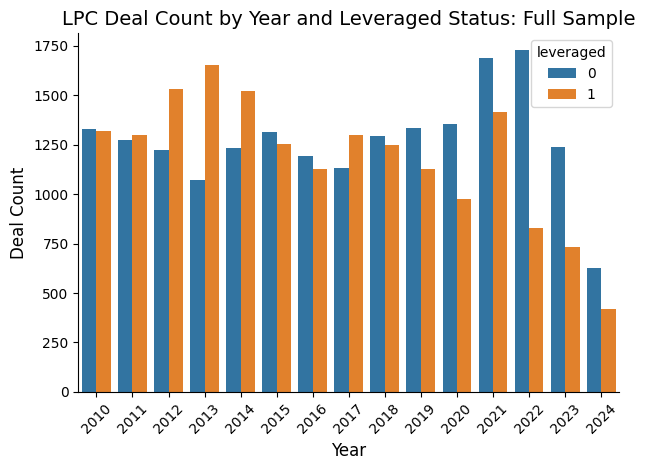

In [298]:
plot_dealcount(dealscan_data, 'Full Sample')
# save the plot as pdf
plt.savefig(os.path.join(overleaf_dir, 'Figures/ds_count_full_sample.png'))

## Split by term loan and revolver

In [299]:
# generate term_loan = 1 if the text "Term Loan" appears in tranche type
dealscan_data['term_loan'] = dealscan_data['tranche_type'].str.contains("Term Loan", case=False, na=False).astype(int)
dealscan_data['revolver'] = dealscan_data['tranche_type'].str.contains("Revolver", case=False, na=False).astype(int)

# keep only term_loan or revolver
dealscan_data = dealscan_data[(dealscan_data['term_loan'] == 1) | (dealscan_data['revolver'] == 1)]

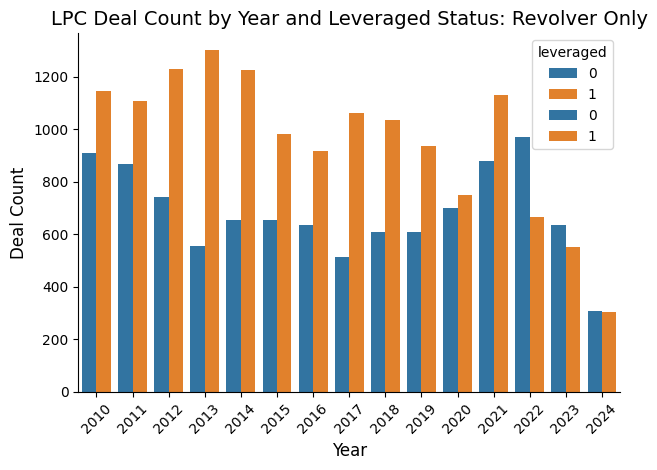

In [300]:
# plots for term_loan only
dealscan_data_term_loan = dealscan_data[dealscan_data['term_loan'] == 1]
plot_dealcount(dealscan_data_term_loan, 'Term Loan Only')
# save the plot as pdf
plt.savefig(os.path.join(overleaf_dir, 'Figures/ds_count_term_loan.png'))

# plots for revolver only
dealscan_data_revolver = dealscan_data[dealscan_data['revolver'] == 1]
plot_dealcount(dealscan_data_revolver, 'Revolver Only')
# save the plot as pdf
plt.savefig(os.path.join(overleaf_dir, 'Figures/ds_count_revolver.png'))

## Merge with Compustat/CRSP

In [301]:
dealscan_new_legacy_link = pd.read_excel('../3. Data/Raw/WRDS_to_LoanConnector_IDs.xlsx')

# Rename columns to lpc_deal_id, packageid, lpc_tranche_id, facilityid
dealscan_new_legacy_link.columns = ['lpc_deal_id', 'packageid', 'lpc_tranche_id', 'facilityid']

# Identify duplicates in the combination of 'lpc_deal_id' and 'lpc_tranche_id'
dealscan_new_legacy_link['dup'] = dealscan_new_legacy_link.duplicated(subset=['lpc_deal_id', 'lpc_tranche_id'], keep=False).astype(int)

# Drop rows where duplicates exist (i.e., 'dup' != 0)
dealscan_new_legacy_link = dealscan_new_legacy_link[dealscan_new_legacy_link['dup'] == 0]

# Drop the 'dup' column (no longer needed)
dealscan_new_legacy_link = dealscan_new_legacy_link.drop(columns=['dup'])

In [302]:
# merge with dealscan_data on lpc_deal_id and lpc_tranche_id
dealscan_merged = dealscan_data.merge(dealscan_new_legacy_link, on=['lpc_deal_id', 'lpc_tranche_id'], how='inner')

In [303]:
dealscan_compustat_link = pd.read_excel('../3. Data/Raw/Dealscan-Compustat_Linking_Database012024.xlsx', sheet_name = 'links')

dealscan_merged = dealscan_merged.merge(dealscan_compustat_link, on='facilityid', how='inner')

# merge gvkey with compustat annual data for now 
dealscan_merged['fyear'] = dealscan_merged['year'] - 1 # use the previous fiscal year financials 
dealscan_comp_crspa_merged = dealscan_merged.merge(comp_crspa_merged, on=['gvkey', 'fyear'], how='inner')

In [304]:
# calculate the interest coverage ratio
dealscan_comp_crspa_merged['interest_expense_by_ebitda'] = dealscan_comp_crspa_merged['xint'] / dealscan_comp_crspa_merged['ebitda']
# describe the interest coverage ratio
dealscan_comp_crspa_merged['interest_expense_by_ebitda'].describe()

count    898075.000000
mean          0.156449
std           3.512410
min        -360.132450
25%           0.064984
50%           0.140852
75%           0.243848
max          89.258065
Name: interest_expense_by_ebitda, dtype: float64

## Nbr of Fin Covenants, perf pricing indicator, sweep indicator (Legacy on deal level)

In [305]:
# collapsed_ds = dealscan_data.groupby(['lpc_deal_id']).agg({
#     'deal_permid': 'first',
#     'deal_active_date': 'min',
#     'borrower_name': 'first',
#     'borrower_id': 'first',
#     'state_province': 'first',
#     'country': 'first',
#     'zip': 'first',
#     'city': 'first',
#     'sic_code': 'first',
#     'sponsor': 'first',
#     'lead_arranger': 'first',
#     'number_of_lenders': 'first',
#     'deal_amount': 'first',
#     'deal_amount_converted': 'first',
#     'deal_purpose': 'first',
#     'deal_amended': 'first',
#     'market_segment': 'first',
#     'seniority_type': 'first',
#     'secured': 'first',
#     'margin_bps': 'first',
#     'leveraged': 'first',
#     'year': 'first',
#     'covenants': 'first', 
#     'all_covenants_financial': 'first',
#     'performance_pricing': 'first',
#     'excess_cf_sweep': 'first',
#     'asset_sales_sweep': 'first',
#     'debt_issue_sweep': 'first',
#     'equity_issue_sweep': 'first',
#     'insurance_proceeds_sweep': 'first',
# }).reset_index()
# # generate num_fin_cov that is the number of commas in all_covenants_financial + 1
# collapsed_ds['num_fin_cov'] = collapsed_ds['all_covenants_financial'].str.count(',') + 1
# # replace missing values with 0
# collapsed_ds['num_fin_cov'] = collapsed_ds['num_fin_cov'].fillna(0)
# # generate perf_pricing dummy that is 1 if performance_pricing is not empty
# collapsed_ds['perf_pricing_dummy'] = collapsed_ds['performance_pricing'].notnull().astype(int)
# # generate sweep dummy that is 1 if any of the sweep covenants is not empty
# sweep_cols = ['excess_cf_sweep', 'asset_sales_sweep', 'debt_issue_sweep', 'equity_issue_sweep', 'insurance_proceeds_sweep']
# collapsed_ds['sweep_dummy'] = collapsed_ds[sweep_cols].notnull().any(axis=1).astype(int)

# # Calculate the average number of num_fin_cov over years
# avg_num_fin_cov = collapsed_ds.groupby('year')['num_fin_cov'].mean().reset_index()
# # Calculate the frequency of perf_pricing_dummy and sweep_dummy over years
# freq_perf_pricing = collapsed_ds.groupby('year')['perf_pricing_dummy'].mean().reset_index()
# freq_sweep = collapsed_ds.groupby('year')['sweep_dummy'].mean().reset_index()
# # Plot the average number of num_fin_cov over years
# plt.figure(figsize=(12, 6))
# plt.plot(avg_num_fin_cov['year'], avg_num_fin_cov['num_fin_cov'], marker='o', label='Average Number of Financial Covenants')
# plt.xlabel('Year')
# plt.ylabel('Average Number of Financial Covenants')
# plt.title('Average Number of Financial Covenants Over Years: Full Sample')
# plt.legend()
# plt.grid(True)
# # save as png
# plt.savefig(os.path.join(overleaf_dir,'Figures/avg_num_fin_cov_fullsample.png'))

# # Plot the frequency of perf_pricing_dummy and sweep_dummy over years
# plt.figure(figsize=(12, 6))
# plt.plot(freq_perf_pricing['year'], freq_perf_pricing['perf_pricing_dummy'], marker='o', label='Performance Pricing Dummy Frequency')
# plt.plot(freq_sweep['year'], freq_sweep['sweep_dummy'], marker='o', label='Sweep Dummy Frequency')
# plt.xlabel('Year')
# plt.ylabel('Frequency')
# plt.title('Frequency of Performance Pricing and Sweep Dummy Over Years: Full Sample')
# plt.legend()
# plt.grid(True)
# # save as png
# plt.savefig(os.path.join(overleaf_dir,'Figures/freq_perf_pricing_sweep_fullsample.png'))

# # keep only leveraged deals (leveraged = 1)
# collapsed_ds_leveraged = collapsed_ds[collapsed_ds['leveraged'] == 1]
# # Calculate the average number of num_fin_cov over years
# avg_num_fin_cov = collapsed_ds_leveraged.groupby('year')['num_fin_cov'].mean().reset_index()
# # Calculate the frequency of perf_pricing_dummy and sweep_dummy over years
# freq_perf_pricing = collapsed_ds_leveraged.groupby('year')['perf_pricing_dummy'].mean().reset_index()
# freq_sweep = collapsed_ds_leveraged.groupby('year')['sweep_dummy'].mean().reset_index()

# plt.figure(figsize=(12, 6))
# plt.plot(avg_num_fin_cov['year'], avg_num_fin_cov['num_fin_cov'], marker='o', label='Average Number of Financial Covenants')
# plt.xlabel('Year')
# plt.ylabel('Average Number of Financial Covenants')
# plt.title('Average Number of Financial Covenants Over Years: Leveraged Deals')
# plt.legend()
# plt.grid(True)
# # save as png
# plt.savefig(os.path.join(overleaf_dir,'Figures/avg_num_fin_cov_leveraged.png'))

# # Plot the frequency of perf_pricing_dummy and sweep_dummy over years
# plt.figure(figsize=(12, 6))
# plt.plot(freq_perf_pricing['year'], freq_perf_pricing['perf_pricing_dummy'], marker='o', label='Performance Pricing Dummy Frequency')
# plt.plot(freq_sweep['year'], freq_sweep['sweep_dummy'], marker='o', label='Sweep Dummy Frequency')
# plt.xlabel('Year')
# plt.ylabel('Frequency')
# plt.title('Frequency of Performance Pricing and Sweep Dummy Over Years: Leveraged Deals')
# plt.legend()
# plt.grid(True)
# # save as png
# plt.savefig(os.path.join(overleaf_dir,'Figures/freq_perf_pricing_sweep_leveraged.png'))

# Finalize DS-Compa Merged Data

In [306]:
# order by lpc_deal_id facilityid lpc_tranche_id packageid and sort by them
dealscan_comp_crspa_merged = dealscan_comp_crspa_merged.sort_values(['lpc_deal_id', 'facilityid', 'lpc_tranche_id', 'packageid'])
dealscan_comp_crspa_merged = dealscan_comp_crspa_merged.reset_index(drop=True)

# put lpc_deal_id facilityid lpc_tranche_id packageid tranchetype and deal_active_date in the first columns
dealscan_comp_crspa_merged = dealscan_comp_crspa_merged[['lpc_deal_id', 'facilityid', 'lpc_tranche_id', 'packageid', 'tranche_type', 'deal_active_date'] + 
                                              [col for col in dealscan_comp_crspa_merged.columns if col not in ['lpc_deal_id', 'facilityid', 'lpc_tranche_id', 'packageid', 'tranchetype', 'deal_active_date']]]

# collapse by lpc_tranche_id and keep only the first entry 
tranche_level_ds_compa = dealscan_comp_crspa_merged.groupby(['lpc_tranche_id']).agg({
    'lpc_deal_id': 'first',
    'packageid': 'first',
    'facilityid': 'first',
    'deal_permid': 'first',
    'deal_active_date': 'min',
    'year': 'first',
    'gvkey': 'first',
    'borrower_name': 'first',
    'borrower_id': 'first',
    'state_province': 'first',
    'country': 'first',
    'zip': 'first',
    'city': 'first',
    'sic_code': 'first',
    'sponsor': 'first',
    'lead_arranger': 'first',
    'number_of_lenders': 'first',
    'deal_amount': 'first',
    'deal_amount_converted': 'first',
    'deal_purpose': 'first',
    'deal_amended': 'first',
    'market_segment': 'first',
    'seniority_type': 'first',
    'secured': 'first',
    'margin_bps': 'first',
    'leveraged': 'first',
    'fyear': 'first',
    'covenants': 'first', 
    'all_covenants_financial': 'first',
    'performance_pricing': 'first',
    'excess_cf_sweep': 'first',
    'asset_sales_sweep': 'first',
    'debt_issue_sweep': 'first',
    'equity_issue_sweep': 'first',
    'insurance_proceeds_sweep': 'first',
    'interest_expense_by_ebitda': 'first',
    'xint': 'first',
    'ebitda': 'first',
    'ebit': 'first',
    'at': 'first',
    'capx': 'first',
    'che': 'first',
    'oancf': 'first',
    'debt': 'first',
    'dlstcd': 'first',
    'dvc': 'first',
    'dividend_payer': 'first',
    'pi': 'first',
    'dp': 'first',
    'excess_interest_30': 'first',
    'excess_interest_loss': 'first',
    'financial_deficit': 'first',
    'immediate_depletion': 'first',
    'intan': 'first',
    'interest_expense_30_rule': 'first',
    'interest_expense_loss_rule': 'first',
    'interest_expense_not_excess': 'first',
    'interest_expense_total_excess': 'first',
    'idit': 'first',
    'investment': 'first',
    'loss_before_interest_expense': 'first',
    'market_to_book': 'first',
    'mnc': 'first',
    'net_interest': 'first',
    'nol': 'first',
    'ppent': 'first',
    'xrd': 'first',
    'sale': 'first',
    'sales_growth': 'first',
    'ret_buy_and_hold': 'first',
    'ret_vol': 'first',
    'z_score': 'first',
    'delta_dcf': 'first',
    'ipodate': 'first',
}).reset_index()

In [307]:
# generate num_fin_cov that is the number of commas in all_covenants_financial + 1
tranche_level_ds_compa['num_fin_cov'] = tranche_level_ds_compa['all_covenants_financial'].str.count(',') + 1
# replace missing values with 0
tranche_level_ds_compa['num_fin_cov'] = tranche_level_ds_compa['num_fin_cov'].fillna(0)
# generate perf_pricing dummy that is 1 if performance_pricing is not empty
tranche_level_ds_compa['perf_pricing_dummy'] = tranche_level_ds_compa['performance_pricing'].notnull().astype(int)
# generate sweep dummy that is 1 if any of the sweep covenants is not empty
sweep_cols = ['excess_cf_sweep', 'asset_sales_sweep', 'debt_issue_sweep', 'equity_issue_sweep', 'insurance_proceeds_sweep']
tranche_level_ds_compa['sweep_dummy'] = tranche_level_ds_compa[sweep_cols].notnull().any(axis=1).astype(int)


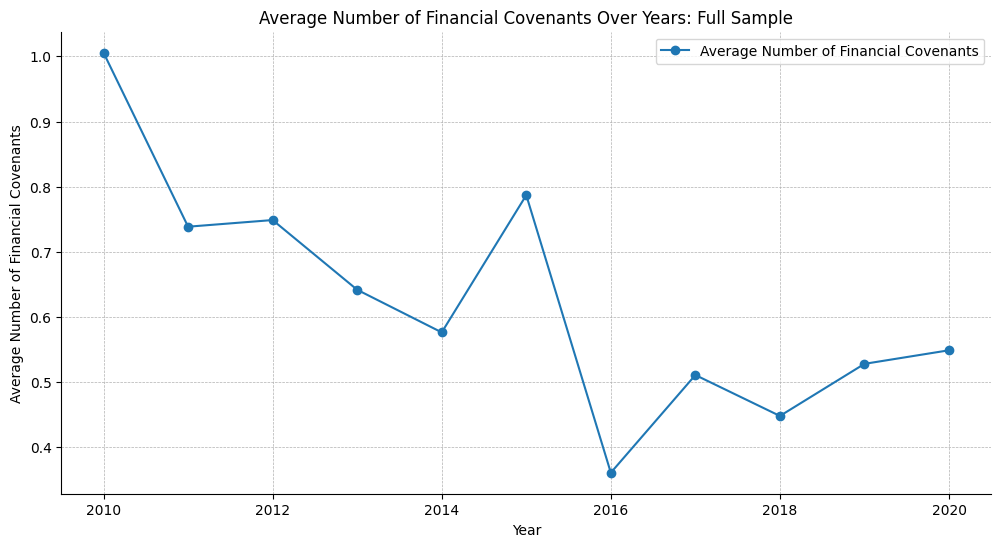

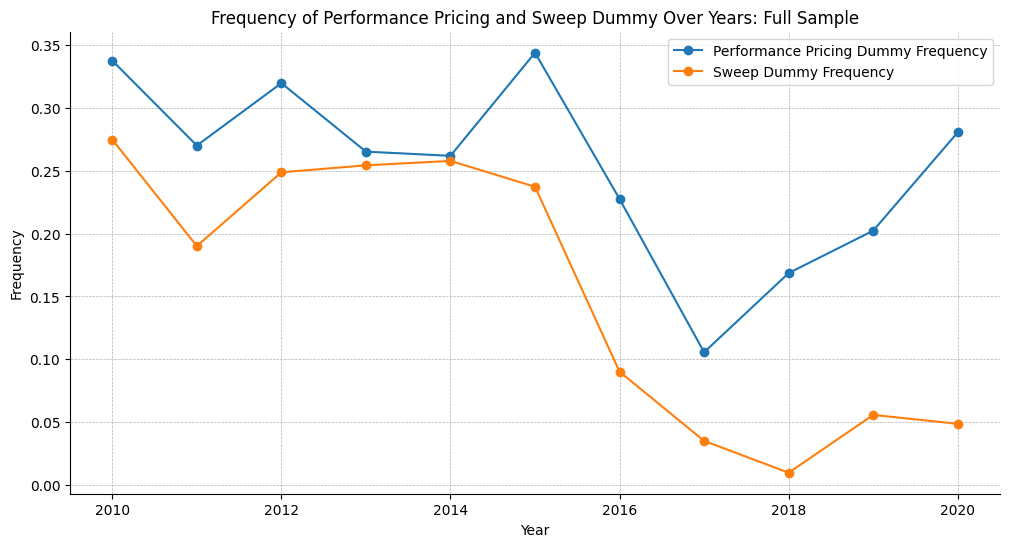

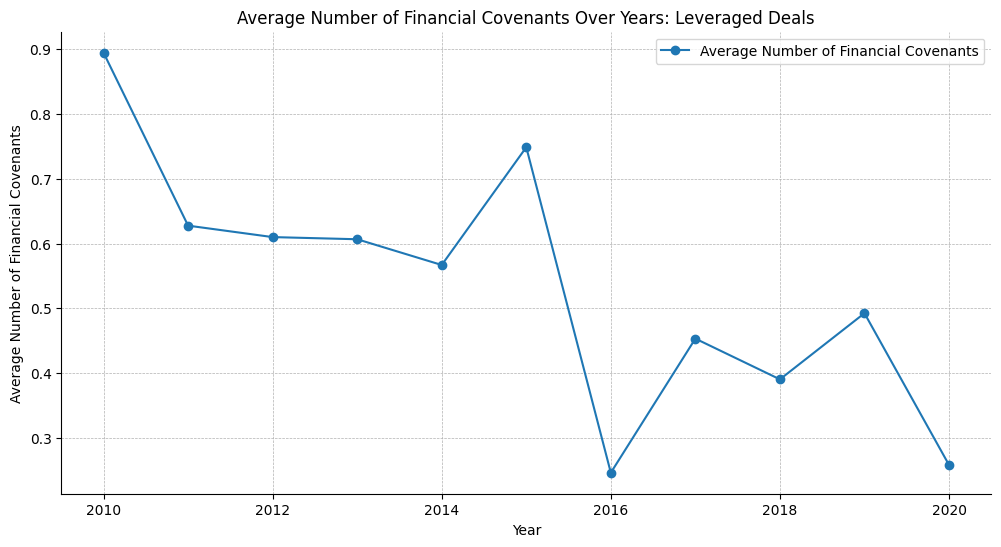

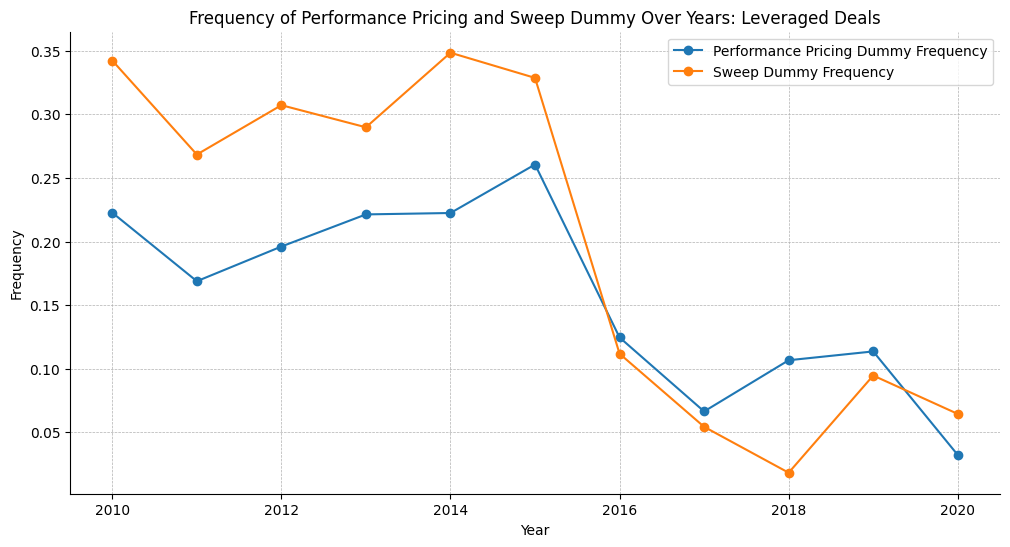

In [308]:
# Calculate the average number of num_fin_cov over years
avg_num_fin_cov = tranche_level_ds_compa.groupby('year')['num_fin_cov'].mean().reset_index()
# Calculate the frequency of perf_pricing_dummy and sweep_dummy over years
freq_perf_pricing = tranche_level_ds_compa.groupby('year')['perf_pricing_dummy'].mean().reset_index()
freq_sweep = tranche_level_ds_compa.groupby('year')['sweep_dummy'].mean().reset_index()

# Plot the average number of num_fin_cov over years
plt.figure(figsize=(12, 6))
plt.plot(avg_num_fin_cov['year'], avg_num_fin_cov['num_fin_cov'], marker='o', label='Average Number of Financial Covenants')
plt.xlabel('Year')
plt.ylabel('Average Number of Financial Covenants')
plt.title('Average Number of Financial Covenants Over Years: Full Sample')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
sns.despine()
# save as png
plt.savefig(os.path.join(overleaf_dir,'Figures/avg_num_fin_cov_fullsample.png'))

# Plot the frequency of perf_pricing_dummy and sweep_dummy over years
plt.figure(figsize=(12, 6))
plt.plot(freq_perf_pricing['year'], freq_perf_pricing['perf_pricing_dummy'], marker='o', label='Performance Pricing Dummy Frequency')
plt.plot(freq_sweep['year'], freq_sweep['sweep_dummy'], marker='o', label='Sweep Dummy Frequency')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Frequency of Performance Pricing and Sweep Dummy Over Years: Full Sample')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
sns.despine()
# save as png
plt.savefig(os.path.join(overleaf_dir,'Figures/freq_perf_pricing_sweep_fullsample.png'))

# keep only leveraged deals (leveraged = 1) and do the same plots
tranche_level_ds_compa_leveraged = tranche_level_ds_compa[tranche_level_ds_compa['leveraged'] == 1]

# Calculate the average number of num_fin_cov over years
avg_num_fin_cov = tranche_level_ds_compa_leveraged.groupby('year')['num_fin_cov'].mean().reset_index()
# Calculate the frequency of perf_pricing_dummy and sweep_dummy over years
freq_perf_pricing = tranche_level_ds_compa_leveraged.groupby('year')['perf_pricing_dummy'].mean().reset_index()
freq_sweep = tranche_level_ds_compa_leveraged.groupby('year')['sweep_dummy'].mean().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(avg_num_fin_cov['year'], avg_num_fin_cov['num_fin_cov'], marker='o', label='Average Number of Financial Covenants')
plt.xlabel('Year')
plt.ylabel('Average Number of Financial Covenants')
plt.title('Average Number of Financial Covenants Over Years: Leveraged Deals')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
sns.despine()
# save as png
plt.savefig(os.path.join(overleaf_dir,'Figures/avg_num_fin_cov_leveraged.png'))

# Plot the frequency of perf_pricing_dummy and sweep_dummy over years
plt.figure(figsize=(12, 6))
plt.plot(freq_perf_pricing['year'], freq_perf_pricing['perf_pricing_dummy'], marker='o', label='Performance Pricing Dummy Frequency')
plt.plot(freq_sweep['year'], freq_sweep['sweep_dummy'], marker='o', label='Sweep Dummy Frequency')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Frequency of Performance Pricing and Sweep Dummy Over Years: Leveraged Deals')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
sns.despine()
# save as png
plt.savefig(os.path.join(overleaf_dir,'Figures/freq_perf_pricing_sweep_leveraged.png'))


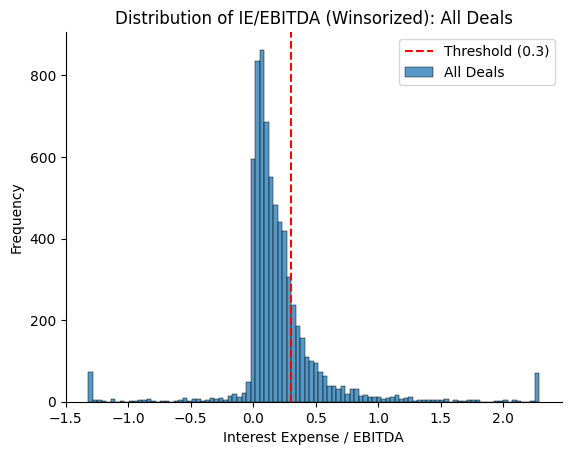

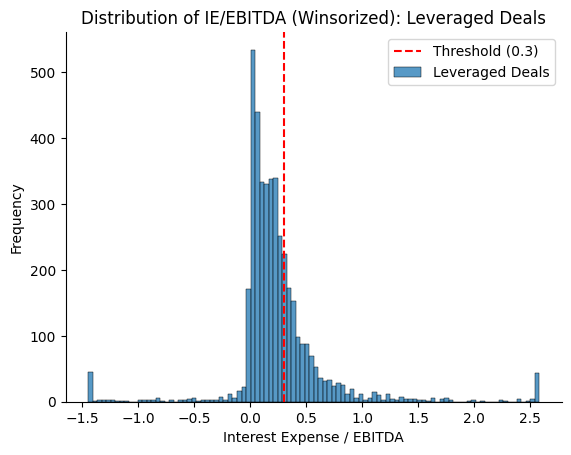

In [309]:
# plot the histogram of winsorized interest_expense_by_ebitda for all deals
interest_expense_winsorized = tranche_level_ds_compa['interest_expense_by_ebitda'].clip(tranche_level_ds_compa['interest_expense_by_ebitda'].quantile(0.01), tranche_level_ds_compa['interest_expense_by_ebitda'].quantile(0.99))
sns.histplot(interest_expense_winsorized, bins=100, label='All Deals')
plt.axvline(x=0.3, color='r', linestyle='--', label='Threshold (0.3)')
plt.xlabel('Interest Expense / EBITDA')
plt.ylabel('Frequency')
plt.title('Distribution of IE/EBITDA (Winsorized): All Deals')
plt.legend()
sns.despine()
plt.savefig(os.path.join(overleaf_dir, 'Figures/ie_ebitda_all_deals.png'))
plt.show()

# plot the histogram of winsorized interest_expense_by_ebitda for leveraged deals only
tranche_level_ds_compa_leveraged = tranche_level_ds_compa[tranche_level_ds_compa['leveraged'] == 1]
interest_expense_winsorized = tranche_level_ds_compa_leveraged['interest_expense_by_ebitda'].clip(tranche_level_ds_compa_leveraged['interest_expense_by_ebitda'].quantile(0.01), tranche_level_ds_compa_leveraged['interest_expense_by_ebitda'].quantile(0.99))
sns.histplot(interest_expense_winsorized, bins=100, label='Leveraged Deals')
plt.axvline(x=0.3, color='r', linestyle='--', label='Threshold (0.3)')
plt.xlabel('Interest Expense / EBITDA')
plt.ylabel('Frequency')
plt.title('Distribution of IE/EBITDA (Winsorized): Leveraged Deals')
plt.legend()
sns.despine()
plt.savefig(os.path.join(overleaf_dir, 'Figures/ie_ebitda_leveraged_deals.png'))
plt.show()

In [310]:
# Define a dictionary mapping SIC code ranges to Fama-French 49 industry classifications
sic_to_industry = [
    # 1 Agric Agriculture
    ((100, 199), 1), ((200, 299), 1), ((700, 799), 1), ((910, 919), 1), ((2048, 2048), 1),
    
    # 2 Food Food Products
    ((2000, 2009), 2), ((2010, 2019), 2), ((2020, 2029), 2), ((2030, 2039), 2), ((2040, 2046), 2),
    ((2050, 2059), 2), ((2060, 2063), 2), ((2070, 2079), 2), ((2090, 2092), 2), ((2095, 2095), 2),
    ((2098, 2099), 2),
    
    # 3 Soda Candy & Soda
    ((2064, 2068), 3), ((2086, 2086), 3), ((2087, 2087), 3), ((2096, 2096), 3), ((2097, 2097), 3),
    
    # 4 Beer Beer & Liquor
    ((2080, 2080), 4), ((2082, 2082), 4), ((2083, 2083), 4), ((2084, 2084), 4), ((2085, 2085), 4),
    
    # 5 Smoke Tobacco Products
    ((2100, 2199), 5),
    
    # 6 Toys Recreation
    ((920, 999), 6), ((3650, 3651), 6), ((3652, 3652), 6), ((3732, 3732), 6), ((3930, 3931), 6), ((3940, 3949), 6),
    
    # 7 Fun Entertainment
    ((7800, 7829), 7), ((7830, 7833), 7), ((7840, 7841), 7), ((7900, 7900), 7), ((7910, 7911), 7),
    ((7920, 7929), 7), ((7930, 7933), 7), ((7940, 7949), 7), ((7980, 7980), 7), ((7990, 7999), 7),
    
    # 8 Books Printing and Publishing
    ((2700, 2709), 8), ((2710, 2719), 8), ((2720, 2729), 8), ((2730, 2739), 8), ((2740, 2749), 8),
    ((2770, 2771), 8), ((2780, 2789), 8), ((2790, 2799), 8),
    
    # 9 Hshld Consumer Goods
    ((2047, 2047), 9), ((2391, 2392), 9), ((2510, 2519), 9), ((2590, 2599), 9), ((2840, 2843), 9),
    ((2844, 2844), 9), ((3160, 3161), 9), ((3170, 3171), 9), ((3172, 3172), 9), ((3190, 3199), 9),
    ((3229, 3229), 9), ((3260, 3260), 9), ((3262, 3263), 9), ((3269, 3269), 9), ((3230, 3231), 9),
    ((3630, 3639), 9), ((3750, 3751), 9), ((3800, 3800), 9), ((3860, 3861), 9), ((3870, 3873), 9),
    ((3910, 3911), 9), ((3914, 3914), 9), ((3915, 3915), 9), ((3960, 3962), 9), ((3991, 3991), 9),
    ((3995, 3995), 9),
    
    # 10 Clths Apparel
    ((2300, 2390), 10), ((3020, 3021), 10), ((3100, 3111), 10), ((3130, 3131), 10), ((3140, 3149), 10),
    ((3150, 3151), 10), ((3963, 3965), 10),
    
    # 11 Hlth Healthcare
    ((8000, 8099), 11),
    
    # 12 MedEq Medical Equipment
    ((3693, 3693), 12), ((3840, 3849), 12), ((3850, 3851), 12),
    
    # 13 Drugs Pharmaceutical Products
    ((2830, 2830), 13), ((2831, 2831), 13), ((2833, 2833), 13), ((2834, 2834), 13), ((2835, 2835), 13),
    ((2836, 2836), 13),
    
    # 14 Chems Chemicals
    ((2800, 2809), 14), ((2810, 2819), 14), ((2820, 2829), 14), ((2850, 2859), 14), ((2860, 2869), 14),
    ((2870, 2879), 14), ((2890, 2899), 14),
    
    # 15 Rubbr Rubber and Plastic Products
    ((3031, 3031), 15), ((3041, 3041), 15), ((3050, 3053), 15), ((3060, 3069), 15), ((3070, 3079), 15),
    ((3080, 3089), 15), ((3090, 3099), 15),
    
    # 16 Txtls Textiles
    ((2200, 2269), 16), ((2270, 2279), 16), ((2280, 2284), 16), ((2290, 2295), 16), ((2297, 2297), 16),
    ((2298, 2298), 16), ((2299, 2299), 16), ((2393, 2395), 16), ((2397, 2399), 16),
    
    # 17 BldMt Construction Materials
    ((800, 899), 17), ((2400, 2439), 17), ((2450, 2459), 17), ((2490, 2499), 17), ((2660, 2661), 17),
    ((2950, 2952), 17), ((3200, 3200), 17), ((3210, 3211), 17), ((3240, 3241), 17), ((3250, 3259), 17),
    ((3261, 3261), 17), ((3264, 3264), 17), ((3270, 3275), 17), ((3280, 3281), 17), ((3290, 3293), 17),
    ((3295, 3299), 17),
    
    # 18 Cnstr Construction
    ((1500, 1511), 18), ((1520, 1529), 18), ((1530, 1539), 18), ((1540, 1549), 18), ((1600, 1699), 18),
    ((1700, 1799), 18),
    
    # 19 Steel Steel Works Etc
    ((3300, 3300), 19), ((3310, 3317), 19), ((3320, 3325), 19), ((3330, 3339), 19), ((3340, 3341), 19),
    ((3350, 3357), 19), ((3360, 3369), 19), ((3370, 3379), 19), ((3390, 3399), 19),
    
    # 20 FabPr Fabricated Products
    ((3400, 3400), 20), ((3443, 3443), 20), ((3444, 3444), 20), ((3460, 3469), 20), ((3470, 3479), 20),
    
# 21 Mach Machinery
    ((3510, 3519), 21), ((3520, 3529), 21), ((3530, 3530), 21), ((3531, 3531), 21), ((3532, 3532), 21),
    ((3533, 3533), 21), ((3534, 3534), 21), ((3535, 3535), 21), ((3536, 3536), 21), ((3538, 3538), 21),
    ((3540, 3549), 21), ((3550, 3559), 21), ((3560, 3569), 21), ((3580, 3580), 21), ((3581, 3581), 21),
    ((3582, 3582), 21), ((3585, 3585), 21), ((3586, 3586), 21), ((3589, 3589), 21), ((3590, 3599), 21),
    
    # 22 ElcEq Electrical Equipment
    ((3600, 3600), 22), ((3610, 3613), 22), ((3620, 3621), 22), ((3623, 3629), 22), ((3640, 3644), 22),
    ((3645, 3645), 22), ((3646, 3646), 22), ((3648, 3649), 22), ((3660, 3660), 22), ((3690, 3690), 22),
    ((3691, 3692), 22), ((3699, 3699), 22),
    
    # 23 Autos Automobiles and Trucks
    ((2296, 2296), 23), ((2396, 2396), 23), ((3010, 3011), 23), ((3537, 3537), 23), ((3647, 3647), 23),
    ((3694, 3694), 23), ((3700, 3700), 23), ((3710, 3710), 23), ((3711, 3711), 23), ((3713, 3713), 23),
    ((3714, 3714), 23), ((3715, 3715), 23), ((3716, 3716), 23), ((3792, 3792), 23), ((3790, 3791), 23),
    ((3799, 3799), 23),
    
    # 24 Aero Aircraft
    ((3720, 3720), 24), ((3721, 3721), 24), ((3723, 3724), 24), ((3725, 3725), 24), ((3728, 3729), 24),
    
    # 25 Ships Shipbuilding, Railroad Equipment
    ((3730, 3731), 25), ((3740, 3743), 25),
    
    # 26 Guns Defense
    ((3760, 3769), 26), ((3795, 3795), 26), ((3480, 3489), 26),
    
    # 27 Gold Precious Metals
    ((1040, 1049), 27),
    
    # 28 Mines Non-Metallic and Industrial Metal Mining
    ((1000, 1009), 28), ((1010, 1019), 28), ((1020, 1029), 28), ((1030, 1039), 28), ((1050, 1059), 28),
    ((1060, 1069), 28), ((1070, 1079), 28), ((1080, 1089), 28), ((1090, 1099), 28), ((1100, 1119), 28),
    ((1400, 1499), 28),
    
    # 29 Coal Coal
    ((1200, 1299), 29),
    
    # 30 Oil Petroleum and Natural Gas
    ((1300, 1300), 30), ((1310, 1319), 30), ((1320, 1329), 30), ((1330, 1339), 30), ((1370, 1379), 30),
    ((1380, 1380), 30), ((1381, 1381), 30), ((1382, 1382), 30), ((1389, 1389), 30), ((2900, 2912), 30),
    ((2990, 2999), 30),
    
    # 31 Util Utilities
    ((4900, 4900), 31), ((4910, 4911), 31), ((4920, 4922), 31), ((4923, 4923), 31), ((4924, 4925), 31),
    ((4930, 4931), 31), ((4932, 4932), 31), ((4939, 4939), 31), ((4940, 4942), 31),
    
    # 32 Telcm Communication
    ((4800, 4800), 32), ((4810, 4813), 32), ((4820, 4822), 32), ((4830, 4839), 32), ((4840, 4841), 32),
    ((4880, 4889), 32), ((4890, 4890), 32), ((4891, 4891), 32), ((4892, 4892), 32), ((4899, 4899), 32),
    
    # 33 PerSv Personal Services
    ((7020, 7021), 33), ((7030, 7033), 33), ((7200, 7200), 33), ((7210, 7212), 33), ((7214, 7214), 33),
    ((7215, 7216), 33), ((7217, 7217), 33), ((7219, 7219), 33), ((7220, 7221), 33), ((7230, 7231), 33),
    ((7240, 7241), 33), ((7250, 7251), 33), ((7260, 7269), 33), ((7270, 7290), 33), ((7291, 7291), 33),
    ((7292, 7299), 33), ((7395, 7395), 33), ((7500, 7500), 33), ((7520, 7529), 33), ((7530, 7539), 33),
    ((7540, 7549), 33), ((7600, 7600), 33), ((7620, 7620), 33), ((7622, 7622), 33), ((7623, 7623), 33),
    ((7629, 7629), 33), ((7630, 7631), 33), ((7640, 7641), 33), ((7690, 7699), 33), ((8100, 8199), 33),
    ((8200, 8299), 33), ((8300, 8399), 33), ((8400, 8499), 33), ((8600, 8699), 33), ((8800, 8899), 33),
    ((7510, 7515), 33),

    # 34 BusSv Business Services
    ((2750, 2759), 34), ((3993, 3993), 34), ((7218, 7218), 34), ((7300, 7300), 34), ((7310, 7319), 34),
    ((7320, 7329), 34), ((7330, 7339), 34), ((7340, 7342), 34), ((7349, 7349), 34), ((7350, 7351), 34),
    ((7352, 7352), 34), ((7353, 7353), 34), ((7359, 7359), 34), ((7360, 7369), 34), ((7374, 7374), 34),
    ((7376, 7376), 34), ((7377, 7377), 34), ((7378, 7378), 34), ((7379, 7379), 34), ((7380, 7380), 34),
    ((7381, 7382), 34), ((7383, 7383), 34), ((7384, 7384), 34), ((7385, 7385), 34), ((7389, 7390), 34),
    ((7391, 7391), 34), ((7392, 7392), 34), ((7393, 7393), 34), ((7394, 7394), 34), ((7395, 7395), 34),
    ((7397, 7397), 34), ((7399, 7399), 34), ((7519, 7519), 34), ((8700, 8700), 34), ((8710, 8713), 34),
    ((8720, 8721), 34), ((8730, 8734), 34), ((8740, 8748), 34), ((8900, 8910), 34), ((8911, 8911), 34),
    ((8920, 8999), 34), ((4220, 4229), 34),
    
    # 35 Hardw Computers
    ((3570, 3579), 35), ((3680, 3680), 35), ((3681, 3681), 35), ((3682, 3682), 35), ((3683, 3683), 35),
    ((3684, 3684), 35), ((3685, 3685), 35), ((3686, 3686), 35), ((3687, 3687), 35), ((3688, 3688), 35),
    ((3689, 3689), 35), ((3695, 3695), 35),
    
    # 36 Softw Computer Software
    ((7370, 7372), 36), ((7373, 7373), 36), ((7375, 7375), 36),
    
    # 37 Chips Electronic Equipment
    ((3622, 3622), 37), ((3661, 3661), 37), ((3662, 3662), 37), ((3663, 3663), 37), ((3664, 3664), 37),
    ((3665, 3665), 37), ((3666, 3666), 37), ((3669, 3669), 37), ((3670, 3679), 37), ((3810, 3810), 37),
    ((3812, 3812), 37),
    
    # 38 LabEq Measuring and Control Equipment
    ((3811, 3811), 38), ((3820, 3820), 38), ((3821, 3821), 38), ((3822, 3822), 38), ((3823, 3823), 38),
    ((3824, 3824), 38), ((3825, 3825), 38), ((3826, 3826), 38), ((3827, 3827), 38), ((3829, 3829), 38),
    ((3830, 3839), 38),
    
    # 39 Paper Business Supplies
    ((2520, 2549), 39), ((2600, 2639), 39), ((2670, 2699), 39), ((2760, 2761), 39), ((3950, 3955), 39),
    
    # 40 Boxes Shipping Containers
    ((2440, 2449), 40), ((2640, 2659), 40), ((3220, 3221), 40), ((3410, 3412), 40),
    
    # 41 Trans Transportation
    ((4000, 4013), 41), ((4040, 4049), 41), ((4100, 4100), 41), ((4110, 4119), 41), ((4120, 4121), 41),
    ((4130, 4131), 41), ((4140, 4142), 41), ((4150, 4151), 41), ((4170, 4173), 41), ((4190, 4199), 41),
    ((4200, 4200), 41), ((4210, 4219), 41), ((4230, 4231), 41), ((4240, 4249), 41), ((4400, 4499), 41),
    ((4500, 4599), 41), ((4600, 4699), 41), ((4700, 4700), 41), ((4710, 4712), 41), ((4720, 4729), 41),
    ((4730, 4739), 41), ((4740, 4749), 41), ((4780, 4780), 41), ((4782, 4782), 41), ((4783, 4783), 41),
    ((4784, 4784), 41), ((4785, 4785), 41), ((4789, 4789), 41),
    
    # 42 Whlsl Wholesale
    ((5000, 5000), 42), ((5010, 5015), 42), ((5020, 5023), 42), ((5030, 5039), 42), ((5040, 5042), 42),
    ((5043, 5043), 42), ((5044, 5044), 42), ((5045, 5045), 42), ((5046, 5046), 42), ((5047, 5047), 42),
    ((5048, 5048), 42), ((5049, 5049), 42), ((5050, 5059), 42), ((5060, 5060), 42), ((5063, 5063), 42),
    ((5064, 5064), 42), ((5065, 5065), 42), ((5070, 5078), 42), ((5080, 5080), 42), ((5081, 5081), 42),
    ((5082, 5082), 42), ((5083, 5083), 42), ((5084, 5084), 42), ((5085, 5085), 42), ((5086, 5087), 42),
    ((5088, 5088), 42), ((5090, 5090), 42), ((5091, 5092), 42), ((5093, 5093), 42), ((5094, 5094), 42),
    ((5099, 5099), 42), ((5100, 5100), 42), ((5110, 5113), 42), ((5120, 5122), 42), ((5130, 5139), 42),
    ((5140, 5149), 42), ((5150, 5159), 42), ((5160, 5169), 42), ((5170, 5172), 42), ((5180, 5182), 42),
    ((5190, 5199), 42),

    # 43 Rtail Retail
    ((5200, 5200), 43), ((5210, 5219), 43), ((5220, 5229), 43), ((5230, 5231), 43), ((5250, 5251), 43),
    ((5260, 5261), 43), ((5270, 5271), 43), ((5300, 5300), 43), ((5310, 5311), 43), ((5320, 5320), 43),
    ((5330, 5331), 43), ((5334, 5334), 43), ((5340, 5349), 43), ((5390, 5399), 43), ((5400, 5400), 43),
    ((5410, 5411), 43), ((5412, 5412), 43), ((5420, 5429), 43), ((5430, 5439), 43), ((5440, 5449), 43),
    ((5450, 5459), 43), ((5460, 5469), 43), ((5490, 5499), 43), ((5500, 5500), 43), ((5510, 5529), 43),
    ((5530, 5539), 43), ((5540, 5549), 43), ((5550, 5559), 43), ((5560, 5569), 43), ((5570, 5579), 43),
    ((5590, 5599), 43), ((5600, 5699), 43), ((5700, 5700), 43), ((5710, 5719), 43), ((5720, 5722), 43),
    ((5730, 5733), 43), ((5734, 5734), 43), ((5735, 5735), 43), ((5736, 5736), 43), ((5750, 5799), 43),
    ((5900, 5900), 43), ((5910, 5912), 43), ((5920, 5929), 43), ((5930, 5932), 43), ((5940, 5940), 43),
    ((5941, 5941), 43), ((5942, 5942), 43), ((5943, 5943), 43), ((5944, 5944), 43), ((5945, 5945), 43),
    ((5946, 5946), 43), ((5947, 5947), 43), ((5948, 5948), 43), ((5949, 5949), 43), ((5950, 5959), 43),
    ((5960, 5969), 43), ((5970, 5979), 43), ((5980, 5989), 43), ((5990, 5990), 43), ((5992, 5992), 43),
    ((5993, 5993), 43), ((5994, 5994), 43), ((5995, 5995), 43), ((5999, 5999), 43),
    
    # 44 Meals Restaurants, Hotels, Motels
    ((5800, 5819), 44), ((5820, 5829), 44), ((5890, 5899), 44), ((7000, 7000), 44), ((7010, 7019), 44),
    ((7040, 7049), 44), ((7213, 7213), 44),
    
    # 45 Banks Banking
    ((6000, 6000), 45), ((6010, 6019), 45), ((6020, 6020), 45), ((6021, 6021), 45), ((6022, 6022), 45),
    ((6023, 6024), 45), ((6025, 6025), 45), ((6026, 6026), 45), ((6027, 6027), 45), ((6028, 6029), 45),
    ((6030, 6036), 45), ((6040, 6059), 45), ((6060, 6062), 45), ((6080, 6082), 45), ((6090, 6099), 45),
    ((6100, 6100), 45), ((6110, 6111), 45), ((6112, 6113), 45), ((6120, 6129), 45), ((6130, 6139), 45),
    ((6140, 6149), 45), ((6150, 6159), 45), ((6160, 6169), 45), ((6170, 6179), 45), ((6190, 6199), 45),
    
    # 46 Insur Insurance
    ((6300, 6300), 46), ((6310, 6319), 46), ((6320, 6329), 46), ((6330, 6331), 46), ((6350, 6351), 46),
    ((6360, 6361), 46), ((6370, 6379), 46), ((6390, 6399), 46), ((6400, 6411), 46),
    
    # 47 RlEst Real Estate
    ((6500, 6500), 47), ((6510, 6510), 47), ((6512, 6512), 47), ((6513, 6513), 47), ((6514, 6514), 47),
    ((6515, 6515), 47), ((6517, 6519), 47), ((6520, 6529), 47), ((6530, 6531), 47), ((6532, 6532), 47),
    ((6540, 6541), 47), ((6550, 6553), 47), ((6590, 6599), 47), ((6610, 6611), 47),
    
    # 48 Fin Trading
    ((6200, 6299), 48), ((6700, 6700), 48), ((6710, 6719), 48), ((6720, 6722), 48), ((6723, 6723), 48),
    ((6724, 6724), 48), ((6725, 6725), 48), ((6726, 6726), 48), ((6730, 6733), 48), ((6740, 6779), 48),
    ((6790, 6791), 48), ((6792, 6792), 48), ((6793, 6793), 48), ((6794, 6794), 48), ((6795, 6795), 48),
    ((6798, 6798), 48), ((6799, 6799), 48),
    
    # 49 Other Almost Nothing
    ((4950, 4959), 49), ((4960, 4961), 49), ((4970, 4971), 49), ((4990, 4991), 49)
]

# Function to map SIC codes to Fama-French 49 industries
def map_sic_to_industry(sic_code):
    for (start, end), industry in sic_to_industry:
        if start <= sic_code <= end:
            return industry
    return None  # Returns None if no match found

# extract sic from sic_code (first 4 string characters) and filter out invalid values
tranche_level_ds_compa = tranche_level_ds_compa[tranche_level_ds_compa['sic_code'].notna()]
tranche_level_ds_compa['sic'] = tranche_level_ds_compa['sic_code'].str[:4].apply(lambda x: int(x) if x.isdigit() else None).dropna().astype(int)

# Map SIC codes to Fama-French 49 industries
tranche_level_ds_compa['ff_48'] = tranche_level_ds_compa['sic'].apply(map_sic_to_industry)

# Count the number of firms in each industry
industry_counts = tranche_level_ds_compa['ff_48'].value_counts().sort_index()

# Create a DataFrame with the industry counts
industry_counts_df = pd.DataFrame(industry_counts).reset_index()
industry_counts_df.columns = ['Industry', 'Number of Firms']

## Summary Statistics of Firms in the Sample

In [311]:
# Generate variables for the summary statistics

from tabulate import tabulate

# dlst_distress if dlstcd starts with 4 or 5
# dlst_distress if dlstcd starts with 4 or 5
tranche_level_ds_compa['dlst_distress'] = tranche_level_ds_compa['dlstcd'].astype(str).str.startswith(('4', '5')).astype(int)
# dlst_merger if dlstcd starts with 2 or 3
tranche_level_ds_compa['dlst_merger'] = tranche_level_ds_compa['dlstcd'].astype(str).str.startswith(('2', '3')).astype(int)

# interest_total = xint / at
tranche_level_ds_compa['interest_total'] = tranche_level_ds_compa['xint'] / tranche_level_ds_compa['at']
# interest_total_excess = interest_expense_total_excess / at
tranche_level_ds_compa['interest_total_excess'] = tranche_level_ds_compa['interest_expense_total_excess'] / tranche_level_ds_compa['at']
# interest_not_excess = interest_expense_not_excess / at
tranche_level_ds_compa['interest_not_excess'] = tranche_level_ds_compa['interest_expense_not_excess'] / tranche_level_ds_compa['at']
# interest_loss = interest_expense_loss_rule / at
tranche_level_ds_compa['interest_loss'] = tranche_level_ds_compa['interest_expense_loss_rule'] / tranche_level_ds_compa['at']
# interest_30 = interest_expense_30_rule / at
tranche_level_ds_compa['interest_30'] = tranche_level_ds_compa['interest_expense_30_rule'] / tranche_level_ds_compa['at']
# net interest < 0
tranche_level_ds_compa['net_interest_neg'] = (tranche_level_ds_compa['net_interest'] < 0).astype(int)
# net interest / EBITDA
tranche_level_ds_compa['net_interest_by_ebitda'] = tranche_level_ds_compa['net_interest'] / tranche_level_ds_compa['ebitda']
# net interest / EBIT
tranche_level_ds_compa['net_interest_by_ebit'] = tranche_level_ds_compa['net_interest'] / tranche_level_ds_compa['ebit']
# delta_dcf / at
tranche_level_ds_compa['delta_dcf_by_at'] = tranche_level_ds_compa['delta_dcf'] / tranche_level_ds_compa['at']
# delta_dcf / ebitda
tranche_level_ds_compa['delta_dcf_by_ebitda'] = tranche_level_ds_compa['delta_dcf'] / tranche_level_ds_compa['ebitda']
# debt / at
tranche_level_ds_compa['debt_by_at'] = tranche_level_ds_compa['debt'] / tranche_level_ds_compa['at']
# interest / debt
tranche_level_ds_compa['interest_by_debt'] = tranche_level_ds_compa['xint'] / tranche_level_ds_compa['debt']
# winsorize at 1% and 99%
# tranche_level_ds_compa['interest_by_debt'] = tranche_level_ds_compa['interest_by_debt'].clip(tranche_level_ds_compa['interest_by_debt'].quantile(0.01), tranche_level_ds_compa['interest_by_debt'].quantile(0.99))
tranche_level_ds_compa.replace([np.inf, -np.inf], np.nan, inplace=True)
# cash / at
tranche_level_ds_compa['cash_by_at'] = tranche_level_ds_compa['che'] / tranche_level_ds_compa['at']
# cash flows / at
tranche_level_ds_compa['cash_flows_by_at'] = tranche_level_ds_compa['oancf'] / tranche_level_ds_compa['at']
# ppent / at
tranche_level_ds_compa['ppent_by_at'] = tranche_level_ds_compa['ppent'] / tranche_level_ds_compa['at']
# total assets = at / 1000
tranche_level_ds_compa['total_asset'] = tranche_level_ds_compa['at'] / 1000

# Dictionary to map variable names to labels
variable_labels = {
    'excess_interest_30': 'Excess Interest (30% Rule)',
    'excess_interest_loss': 'Excess Interest (Loss Rule)',
    'loss_before_interest_expense': 'Loss Before Interest Expense',
    'interest_total': 'Interest Expense (Total) / Assets',
    'interest_not_excess': 'Interest Expense (Not Excess) / Assets',
    'interest_loss': 'Interest Expense (Excess Loss Rule) / Assets',
    'interest_30': 'Interest Expense (Excess 30% Rule) / Assets',
    'interest_total_excess': 'Interest Expense (Total Excess 30% Rule) / Assets',
    'net_interest_neg': 'Net Interest < 0',
    'net_interest_by_ebitda': 'Net Interest / EBITDA',
    'net_interest_by_ebit': 'Net Interest / EBIT',
    'delta_dcf_by_at': 'Net Debt Issues / Assets',
    'delta_dcf_by_ebitda': 'Net Debt Issues / EBITDA',
    'debt_by_at': 'Debt / Assets',
    'interest_by_debt': 'Interest Expense / Debt',
    'cash_by_at': 'Cash / Assets',
    'cash_flows_by_at': 'Cash Flows / Assets',
    'ppent_by_at': 'PP&E / Assets',
    'total_asset': 'Assets ($Billion)',
    'dividend_payer': 'Dividend Payer',
    'z_score': 'Z-Score',
    'sales_growth': 'Sales Growth',
    'nol': 'Net Operating Loss',
    'market_to_book': 'Market to Book Ratio',
    'ret_buy_and_hold': 'Buy and Hold Return',
    'ret_vol': 'Return Volatility',
    'financial_deficit': 'Financial Deficit',
    'immediate_depletion': 'Immediate Depletion',
    'mnc': 'Multinational Corporation',
    'leveraged': 'Leveraged',
}

# Calculate summary statistics for the variables in variable_labels
summary_stats_all = tranche_level_ds_compa[variable_labels.keys()].describe().transpose()

# Rename the index using the variable labels
summary_stats_all.rename(index=variable_labels, inplace=True)

# Convert to LaTeX table with specified number format and labels
summary_stats_all.columns = ['Count', 'Mean', 'Std. Dev.', 'Min', 'P25', 'Median', 'P75', 'Max']
latex_table = tabulate(summary_stats_all, headers="keys", tablefmt="latex", floatfmt=(".0f", ".0f", ".2f", ".2f", ".2f", ".2f", ".2f", ".2f", ".2f"))

# Modify \hline to \hline\hline right after \begin{tabular}{lrrrrrrrr}
latex_table = latex_table.replace("\\begin{tabular}{lrrrrrrrr}\n\\hline", "\\begin{tabular}{lrrrrrrrr}\n\\hline\\hline")

# Modify \hline to \hline\hline right before \end{tabular}
latex_table = latex_table.replace("\\hline\n\\end{tabular}", "\\hline\\hline\n\\end{tabular}")

# Print or save the LaTeX table
print(latex_table)
with open(os.path.join(overleaf_dir, 'Tables/summary_stats_all.tex'), 'w') as f:
    f.write(latex_table)


\begin{tabular}{lrrrrrrrr}
\hline\hline
                                                   &   Count &   Mean &   Std. Dev. &     Min &   P25 &   Median &   P75 &     Max \\
\hline
 Excess Interest (30\% Rule)                        &    6958 &   0.26 &        0.44 &    0.00 &  0.00 &     0.00 &  1.00 &    1.00 \\
 Excess Interest (Loss Rule)                       &    6958 &   0.23 &        0.42 &    0.00 &  0.00 &     0.00 &  0.00 &    1.00 \\
 Loss Before Interest Expense                      &    6958 &   0.23 &        0.42 &    0.00 &  0.00 &     0.00 &  0.00 &    1.00 \\
 Interest Expense (Total) / Assets                 &    6958 &   0.02 &        0.02 &    0.00 &  0.01 &     0.02 &  0.03 &    0.47 \\
 Interest Expense (Not Excess) / Assets            &    6958 &   0.01 &        0.01 &    0.00 &  0.00 &     0.01 &  0.02 &    0.13 \\
 Interest Expense (Excess Loss Rule) / Assets      &    6958 &   0.01 &        0.02 &    0.00 &  0.00 &     0.00 &  0.00 &    0.47 \\
 Interest Expe

# Preliminary Analysis

In [312]:
# treated = 1 if interest_expense_by_ebitda > 0.3 or interest_expense_by_ebitda < 0
#tranche_level_ds_compa['treated'] = ((tranche_level_ds_compa['interest_expense_by_ebitda'] > 0.3) | (tranche_level_ds_compa['interest_expense_by_ebitda'] < 0)).astype(int)

tranche_level_ds_compa['treated'] = (tranche_level_ds_compa['interest_expense_by_ebitda'] > 0.3).astype(int)

# post = 1 if year > 2018 (2018 as hold-out period)
tranche_level_ds_compa['post'] = (tranche_level_ds_compa['year'] > 2018).astype(int)

# Generate the interaction term
tranche_level_ds_compa['treated_post'] = tranche_level_ds_compa['treated'] * tranche_level_ds_compa['post']

# Generate the dummy variable for each year in the original data frame
year_dummies = pd.get_dummies(tranche_level_ds_compa['year'], prefix='year', drop_first=False).astype(int)

# Generate interaction terms for each year dummy and the treated_post variable, ensuring integer output
interactions = year_dummies.apply(lambda x: (x * tranche_level_ds_compa['treated']).astype(int))

# Rename the interaction columns to have 'treated_year' as names
interactions.columns = [f'treated_{col}' for col in year_dummies.columns]

# Add the year dummies and interaction terms back to the original data frame
tranche_level_ds_compa = pd.concat([tranche_level_ds_compa, year_dummies, interactions], axis=1)

# save as .dta with version=117
tranche_level_ds_compa.to_stata('../3. Data/Processed/tranche_level_ds_compa.dta', version=117)


In [313]:
import stata_setup
stata_setup.config('/Applications/Stata/', 'se', splash=True)

In [314]:
%%stata
use "../3. Data/Processed/tranche_level_ds_compa.dta", clear
global overleaf_dir "/Users/zrsong/Dropbox (MIT)/Apps/Overleaf/M&A Debt"

* list of controls in regression 
gen log_at = log(at)
gen secured_dummy = 0 
replace secured_dummy = 1 if secured == "Yes"
local controls "log_at cash_flows_by_at market_to_book ppent_by_at debt_by_at cash_by_at sales_growth dividend_payer z_score nol"
local deal_controls "leveraged deal_amount_converted secured_dummy"

* label controls and treated, post, and treated_post
label variable log_at "Log Total Assets"
label variable cash_flows_by_at "Cash Flows / Assets"
label variable market_to_book "Market to Book Ratio"
label variable ppent_by_at "PP\&E / Assets"
label variable debt_by_at "Debt / Assets"
label variable cash_by_at "Cash / Assets"
label variable sales_growth "Sales Growth"
label variable dividend_payer "Dividend Payer"
label variable z_score "Z-Score"
label variable nol "Net Operating Loss"

label variable leveraged "Leveraged"
label variable deal_amount_converted "Deal Amount ($)"
label variable secured_dummy "Secured"

label variable treated "Treated"
label variable post "Post"
label variable treated_post "Treated x Post"

reghdfe margin_bps treated treated_post, absorb(year ff_48) vce(cluster gvkey)
estimates store m1
reghdfe margin_bps treated treated_post, absorb(year gvkey) vce(cluster gvkey)
estimates store m2
reghdfe margin_bps treated treated_post `controls', absorb(year ff_48) vce(cluster gvkey)
estimates store m3
reghdfe margin_bps treated treated_post `controls', absorb(year gvkey) vce(cluster gvkey)
estimates store m4
reghdfe margin_bps treated treated_post `controls' `deal_controls', absorb(year ff_48) vce(cluster gvkey)
estimates store m5
reghdfe margin_bps treated treated_post `controls' `deal_controls', absorb(year gvkey) vce(cluster gvkey)
estimates store m6

* save the results (esttab) using overleaf_dir
esttab m1 m2 m3 m4 m5 m6 using "$overleaf_dir/Tables/margin_did.tex", replace ///
nodepvars nomti nonum collabels(none) label b(3) se(3) parentheses ///
star(* 0.10 ** 0.05 *** 0.01) ar2 plain lines fragment noconstant

*********** Dynamic Regressions ***********
local dynamic_treated "treated_year_2010 treated_year_2011 treated_year_2012 treated_year_2013 treated_year_2014 treated_year_2015 treated_year_2016 treated_year_2017 treated_year_2019 treated_year_2020"

reghdfe margin_bps `dynamic_treated' `controls' `deal_controls', absorb(fyear ff_48) vce(cluster ff_48)
mat c = e(b)'
mata st_matrix("srdvcovbt",sqrt(diagonal(st_matrix("e(V)"))))
mat res = c , srdvcovbt

esttab mat(res) using "../5. Results/Tables/margin_did_dynamic_ff48.csv", replace mlab(none)

reghdfe margin_bps `dynamic_treated' `controls' `deal_controls', absorb(fyear gvkey) vce(cluster gvkey)
mat c = e(b)'
mata st_matrix("srdvcovbt",sqrt(diagonal(st_matrix("e(V)"))))
mat res = c , srdvcovbt

esttab mat(res) using "../5. Results/Tables/margin_did_dynamic_gvkey.csv", replace mlab(none)

*********** Dynamic Regressions (num of financial covenants) ***********
reghdfe num_fin_cov `dynamic_treated' `controls' `deal_controls', absorb(fyear ff_48) vce(cluster ff_48)
mat c = e(b)'
mata st_matrix("srdvcovbt",sqrt(diagonal(st_matrix("e(V)"))))
mat res = c , srdvcovbt

esttab mat(res) using "../5. Results/Tables/num_fin_cov_did_dynamic_ff48.csv", replace mlab(none)

reghdfe num_fin_cov `dynamic_treated' `controls' `deal_controls', absorb(fyear gvkey) vce(cluster gvkey)
mat c = e(b)'
mata st_matrix("srdvcovbt",sqrt(diagonal(st_matrix("e(V)"))))
mat res = c , srdvcovbt

esttab mat(res) using "../5. Results/Tables/num_fin_cov_did_dynamic_gvkey.csv", replace mlab(none)

*********** Dynamic Regressions (perf_pricing_dummy) ***********
reghdfe perf_pricing_dummy `dynamic_treated' `controls' `deal_controls', absorb(fyear ff_48) vce(cluster ff_48)
mat c = e(b)'
mata st_matrix("srdvcovbt",sqrt(diagonal(st_matrix("e(V)"))))
mat res = c , srdvcovbt

esttab mat(res) using "../5. Results/Tables/perf_pricing_dummy_did_dynamic_ff48.csv", replace mlab(none)

reghdfe perf_pricing_dummy `dynamic_treated' `controls' `deal_controls', absorb(fyear gvkey) vce(cluster gvkey)
mat c = e(b)'
mata st_matrix("srdvcovbt",sqrt(diagonal(st_matrix("e(V)"))))
mat res = c , srdvcovbt

esttab mat(res) using "../5. Results/Tables/perf_pricing_dummy_did_dynamic_gvkey.csv", replace mlab(none)

*********** Dynamic Regressions (sweep_dummy) ***********
reghdfe sweep_dummy `dynamic_treated' `controls' `deal_controls', absorb(fyear ff_48) vce(cluster ff_48)
mat c = e(b)'
mata st_matrix("srdvcovbt",sqrt(diagonal(st_matrix("e(V)"))))
mat res = c , srdvcovbt

esttab mat(res) using "../5. Results/Tables/sweep_dummy_did_dynamic_ff48.csv", replace mlab(none)

reghdfe sweep_dummy `dynamic_treated' `controls' `deal_controls', absorb(fyear gvkey) vce(cluster gvkey)
mat c = e(b)'
mata st_matrix("srdvcovbt",sqrt(diagonal(st_matrix("e(V)"))))
mat res = c , srdvcovbt

esttab mat(res) using "../5. Results/Tables/sweep_dummy_did_dynamic_gvkey.csv", replace mlab(none)



. use "../3. Data/Processed/tranche_level_ds_compa.dta", clear

. global overleaf_dir "/Users/zrsong/Dropbox (MIT)/Apps/Overleaf/M&A Debt"

. 
. * list of controls in regression 
. gen log_at = log(at)

. gen secured_dummy = 0 

. replace secured_dummy = 1 if secured == "Yes"
(3,645 real changes made)

. local controls "log_at cash_flows_by_at market_to_book ppent_by_at debt_by_at
>  cash_by_at sales_growth dividend_payer z_score nol"

. local deal_controls "leveraged deal_amount_converted secured_dummy"

. 
. * label controls and treated, post, and treated_post
. label variable log_at "Log Total Assets"

. label variable cash_flows_by_at "Cash Flows / Assets"

. label variable market_to_book "Market to Book Ratio"

. label variable ppent_by_at "PP\&E / Assets"

. label variable debt_by_at "Debt / Assets"

. label variable cash_by_at "Cash / Assets"

. label variable sales_growth "Sales Growth"

. label variable dividend_payer "Dividend Payer"

. label variable z_score "Z-Score"

. la

/var/folders/n2/pgdf58ms1yd3ch8xjn9fmpmm0000gq/T/ipykernel_79359/150826066.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  result = result.applymap(lambda x: str(x).replace('="', '').replace('"', ''))
/var/folders/n2/pgdf58ms1yd3ch8xjn9fmpmm0000gq/T/ipykernel_79359/150826066.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  result = result.applymap(lambda x: str(x).replace('="', '').replace('"', ''))


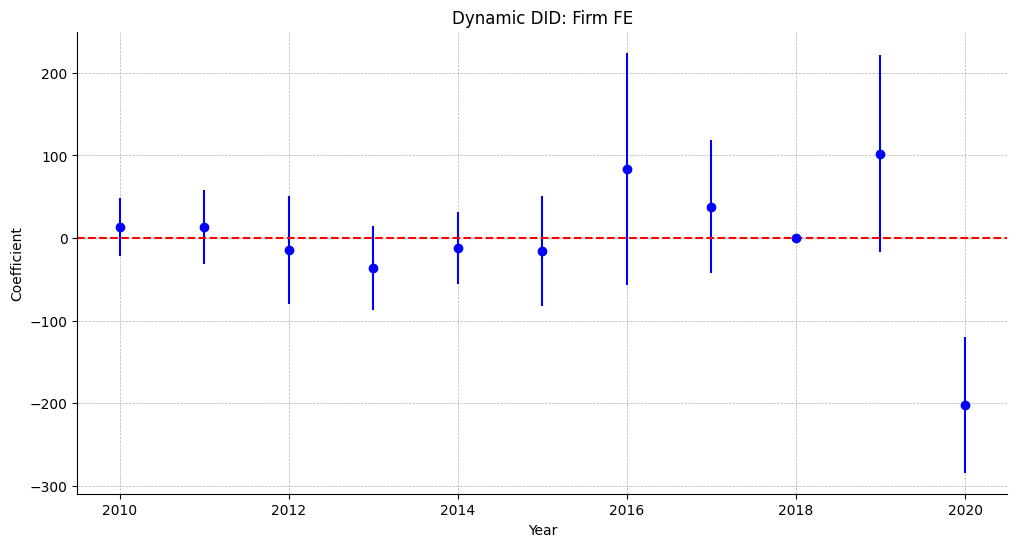

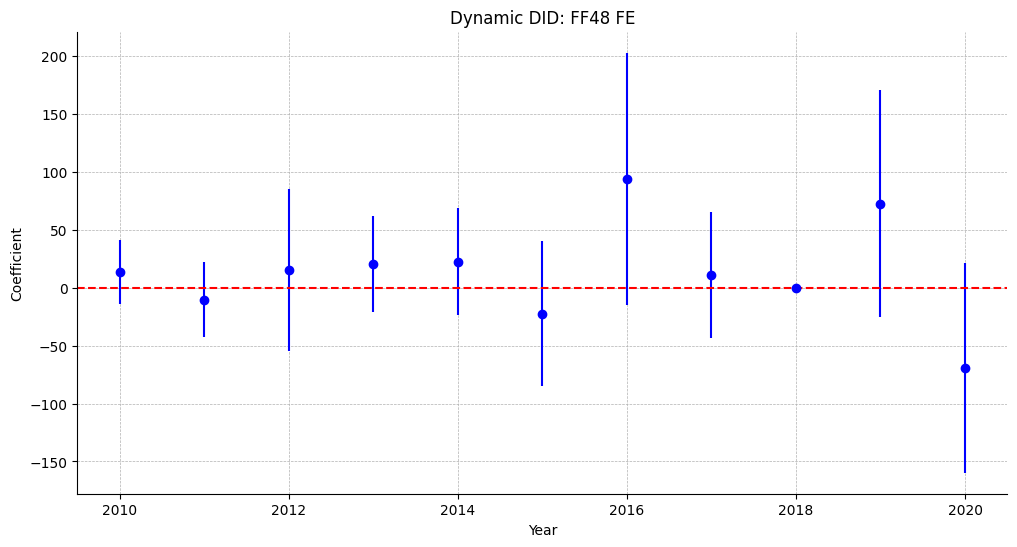

In [ ]:
def plot_dynamic_did(result, title):    
    # Remove unwanted characters from the column names and values
    result = pd.read_csv(f'../5. Results/Tables/{result}.csv')
    result.columns = result.columns.str.replace('="', '').str.replace('"', '')
    result = result.apply(lambda x: x.str.replace('="', '').replace('"', '') if x.dtype == "object" else x)

    # Rename columns as Year, Coefficient, and Standard Error
    result.columns = ['Year', 'Coefficient', 'Standard Error']

    # keep only the rows with treated_year
    result = result[result['Year'].str.startswith('treated_year')]

    # destring the Year column
    result['Year'] = result['Year'].str.replace('treated_year_', '').astype(int)

    # destring coefficient and standard error
    result['Coefficient'] = result['Coefficient'].astype(float)
    result['Standard Error'] = result['Standard Error'].astype(float)

    # Plot the dynamic treatment effect (Coefficient across years with 1.96 standard error bands)
    plt.figure(figsize=(12, 6))
    plt.errorbar(result['Year'], result['Coefficient'], yerr=1.96*result['Standard Error'], fmt='o', color='blue')
    plt.axhline(y=0, color='red', linestyle='--')
    plt.scatter(2018, 0, color='blue', zorder=5)  # Add a dot in year 2018 at 0
    plt.title(title)
    plt.xlabel('Year')
    plt.ylabel('Coefficient')
    plt.grid(True, linestyle='--', linewidth=0.5)
    sns.despine()


/var/folders/n2/pgdf58ms1yd3ch8xjn9fmpmm0000gq/T/ipykernel_79359/150826066.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  result = result.applymap(lambda x: str(x).replace('="', '').replace('"', ''))
/var/folders/n2/pgdf58ms1yd3ch8xjn9fmpmm0000gq/T/ipykernel_79359/150826066.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  result = result.applymap(lambda x: str(x).replace('="', '').replace('"', ''))
/var/folders/n2/pgdf58ms1yd3ch8xjn9fmpmm0000gq/T/ipykernel_79359/150826066.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  result = result.applymap(lambda x: str(x).replace('="', '').replace('"', ''))
/var/folders/n2/pgdf58ms1yd3ch8xjn9fmpmm0000gq/T/ipykernel_79359/150826066.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  result = result.applymap(lambda x: str(x).replace('="', '').replace('"', ''))
/var/folders/n2/pgdf58ms1yd3

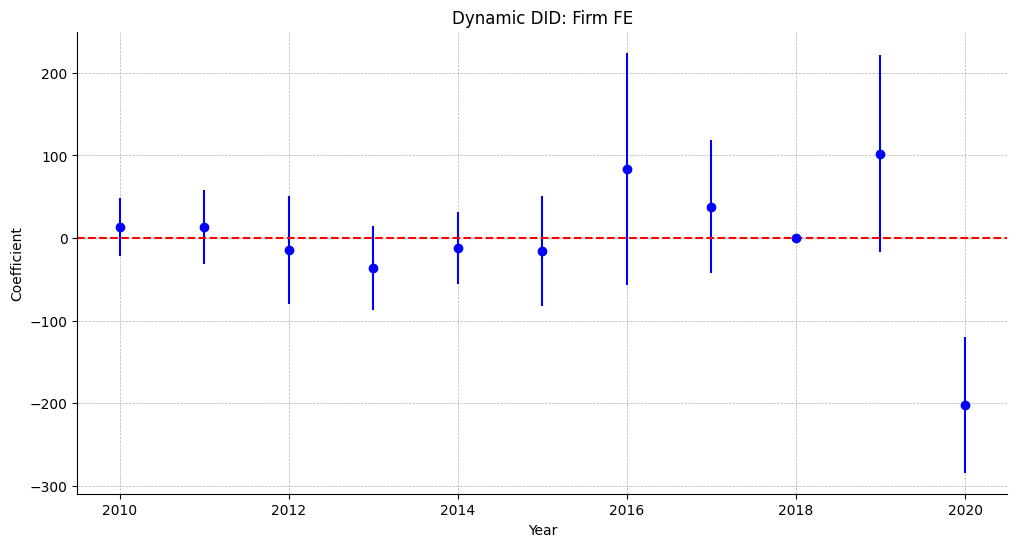

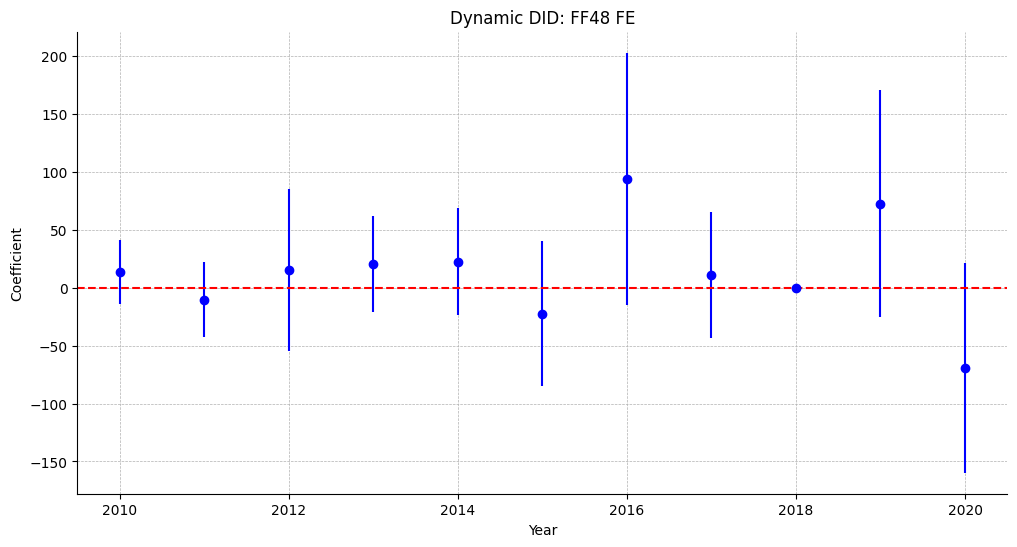

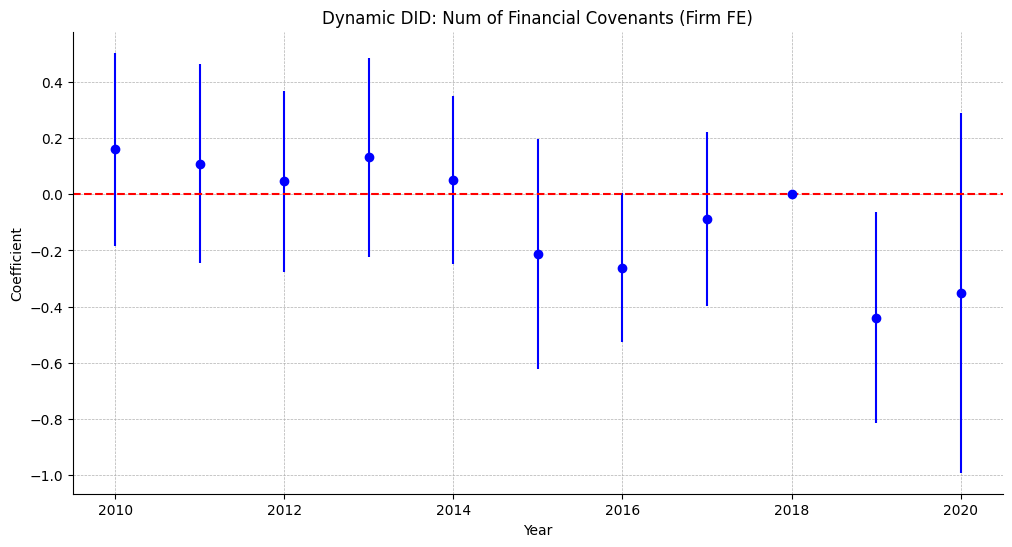

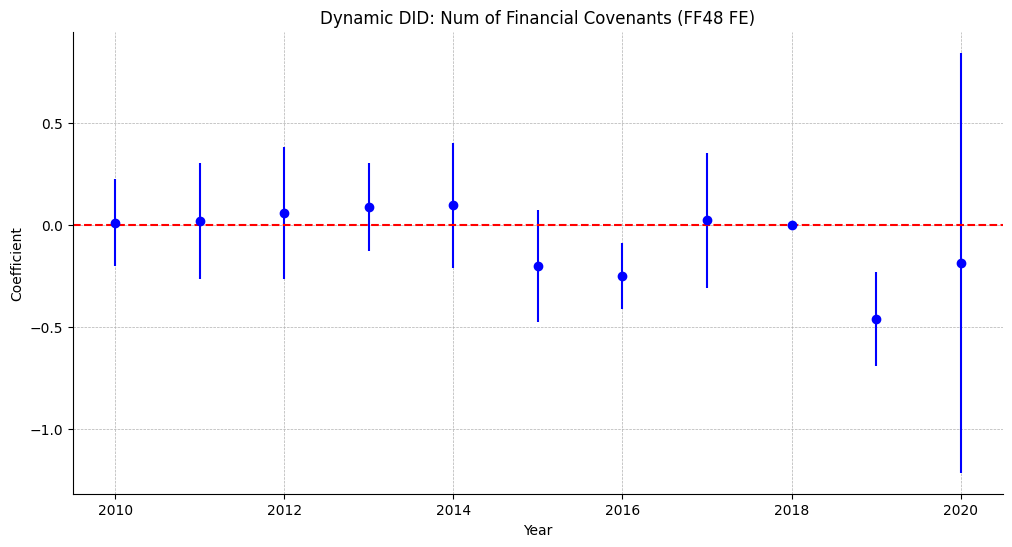

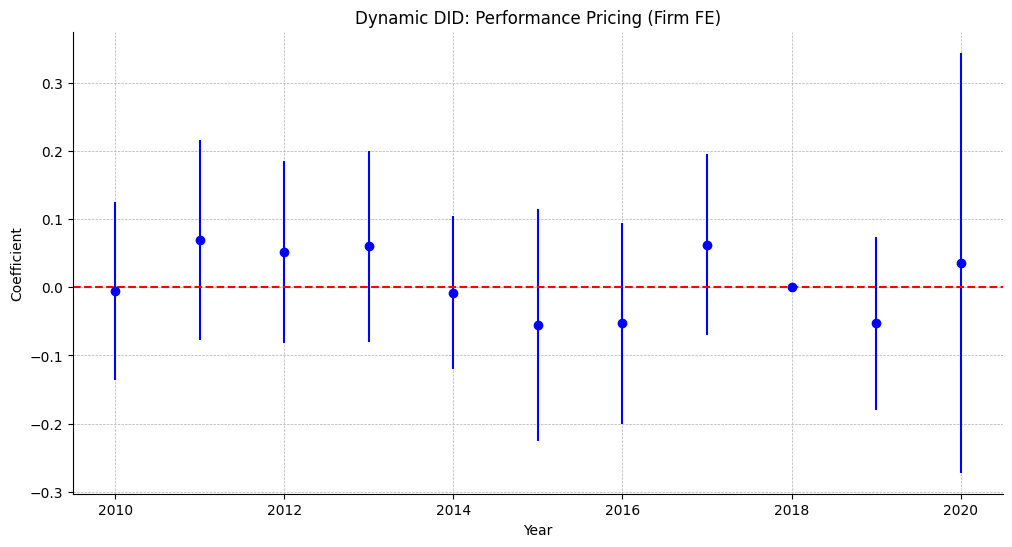

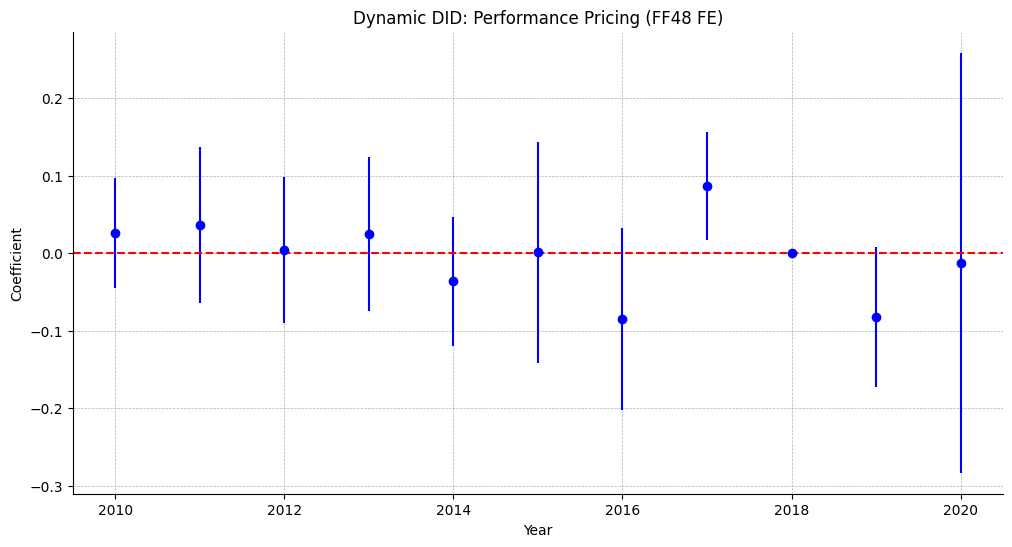

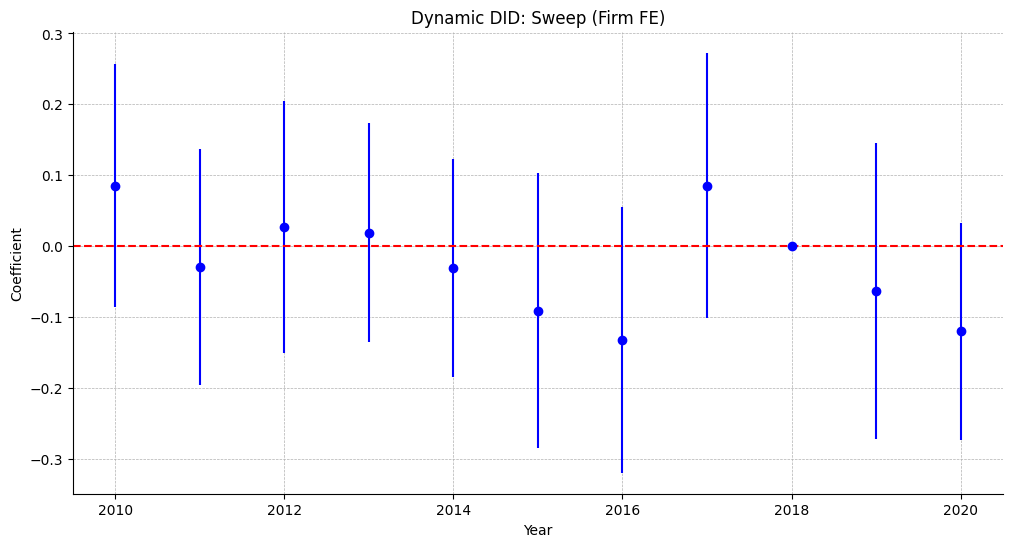

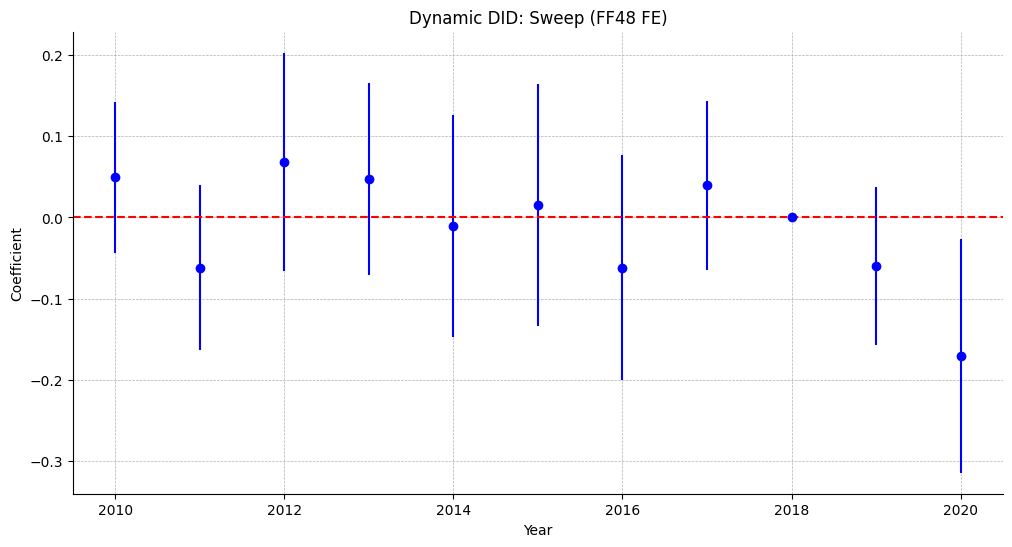

In [315]:
plot_dynamic_did('margin_did_dynamic_gvkey', 'Dynamic DID: Firm FE')
# save the plot as a .png file to the overleaf directory
plt.savefig(f'{overleaf_dir}/Figures/margin_did_dynamic_gvkey.png')
plot_dynamic_did('margin_did_dynamic_ff48', 'Dynamic DID: FF48 FE')
# save the plot as a .png file to the overleaf directory
plt.savefig(f'{overleaf_dir}/Figures/margin_did_dynamic_ff48.png')

plot_dynamic_did('num_fin_cov_did_dynamic_gvkey', 'Dynamic DID: Num of Financial Covenants (Firm FE)')
# save the plot as a .png file to the overleaf directory
plt.savefig(f'{overleaf_dir}/Figures/num_fin_cov_did_dynamic_gvkey.png')
plot_dynamic_did('num_fin_cov_did_dynamic_ff48', 'Dynamic DID: Num of Financial Covenants (FF48 FE)')
# save the plot as a .png file to the overleaf directory
plt.savefig(f'{overleaf_dir}/Figures/num_fin_cov_did_dynamic_ff48.png')

plot_dynamic_did('perf_pricing_dummy_did_dynamic_gvkey', 'Dynamic DID: Performance Pricing (Firm FE)')
# save the plot as a .png file to the overleaf directory
plt.savefig(f'{overleaf_dir}/Figures/perf_pricing_dummy_did_dynamic_gvkey.png')
plot_dynamic_did('perf_pricing_dummy_did_dynamic_ff48', 'Dynamic DID: Performance Pricing (FF48 FE)')
# save the plot as a .png file to the overleaf directory
plt.savefig(f'{overleaf_dir}/Figures/perf_pricing_dummy_did_dynamic_ff48.png')

plot_dynamic_did('sweep_dummy_did_dynamic_gvkey', 'Dynamic DID: Sweep (Firm FE)')
# save the plot as a .png file to the overleaf directory
plt.savefig(f'{overleaf_dir}/Figures/sweep_dummy_did_dynamic_gvkey.png')
plot_dynamic_did('sweep_dummy_did_dynamic_ff48', 'Dynamic DID: Sweep (FF48 FE)')
# save the plot as a .png file to the overleaf directory
plt.savefig(f'{overleaf_dir}/Figures/sweep_dummy_did_dynamic_ff48.png')
